# **FYP - AI Driven Music Recommedation System Approach**

# Getting APIs and Libraries

In [ ]:
!pip install spotipy
!pip install google-api-python-client google-auth-httplib2 google-auth-oauthlib
!pip install google-auth google-auth-oauthlib
!pip install google-auth google-auth-oauthlib google-auth-httplib2
!pip install gdown googlemaps pandas
!pip install pandas numpy matplotlib seaborn tensorflow scikeras
!pip install --upgrade imbalanced-learn scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.0/252.0 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for googlemaps: filename=googlemaps-4.10.0-py3-none-any.whl size=40712 sha256=73626decbc950b970cea9db8c77edb134b52fc7869c7e4369fdbfa9aeabd68b8
  Stored in directory: /root/.cache/pip/wheels/17/f8/79/999d5d37118fd35d7219ef57933eb9d09886c4c4503a800f84
Successfully built googlemaps
INFO: pip is looking at multiple versions of scikeras to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 39.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1

### Connect Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Save Files to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

def save_to_drive(file_name, destination_path):
    """
    Saves a file to Google Drive.

    Parameters:
    - file_name: The name of the file to save (e.g., 'my_data.csv').
    - destination_path: The path within Google Drive where the file should be saved (e.g., '/My Drive/Colab Notebooks/').
    """
    # Ensure the destination path starts with '/content/drive/My Drive/'
    if not destination_path.startswith('/content/drive/My Drive/'):
        print("The destination path must start with '/content/drive/My Drive/'.")
        return

    # Construct the full path and save the file
    full_path = destination_path + file_name
    try:
        with open(full_path, 'w') as f:
            f.write("Your data here")  # Replace this line with your actual data saving logic
        print(f"File {file_name} saved successfully to {destination_path}.")
    except Exception as e:
        print(f"Failed to save file {file_name} to {destination_path}. Error: {e}")





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Saved Tracks

### Fetch Saved Tracks

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd

# Your Spotify API credentials
CLIENT_ID =
CLIENT_SECRET =
REDIRECT_URI =
open_browser=False
SCOPE = 'user-library-read'

# Authenticate with Spotify
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=CLIENT_ID, client_secret=CLIENT_SECRET, redirect_uri=REDIRECT_URI, scope=SCOPE,open_browser=False))

def get_saved_tracks(sp):
    tracks = []
    results = sp.current_user_saved_tracks()
    while results:
        tracks.extend(results['items'])
        results = sp.next(results)
    return tracks

def tracks_to_df(tracks):
    track_data = [{
        'added_at': item['added_at'],
        'id': item['track']['id'],
        'track name': item['track']['name'],
        'popularity': item['track']['popularity'],
        'uri': item['track']['uri'],
        'artist_id': item['track']['artists'][0]['id'],  # Note: Only considering the first artist
        'artist': item['track']['artists'][0]['name'],
        'album': item['track']['album']['name'],
        'release_date': item['track']['album']['release_date'],
        'duration_ms': item['track']['duration_ms']
    } for item in tracks]
    return pd.DataFrame(track_data)

import time

def get_audio_features_batch(sp, track_ids):
    success = False
    retries = 0
    features_data = []
    while not success and retries < 5:  # Limit retries to prevent infinite loops
        try:
            features_list = sp.audio_features(track_ids)
            features_data = [{key: features[key] for key in ['id',
                                                             'danceability',
                                                             'energy',
                                                             'key',
                                                             'loudness',
                                                             'mode',
                                                             'speechiness',
                                                             'acousticness',
                                                             'instrumentalness',
                                                             'liveness',
                                                             'valence',
                                                             'tempo',
                                                             'time_signature']} for features in features_list if features]
            success = True
        except spotipy.SpotifyException as e:
            if e.http_status == 429:
                retry_after = int(e.headers.get('Retry-After', 1))  # Default to 1 second if header is missing
                print(f"Rate limit exceeded, retrying in {retry_after} seconds.")
                time.sleep(retry_after + 1)  # Adding a buffer to ensure compliance
                retries += 1
            else:
                raise  # Re-raise the exception if it's not a rate limit error
    return pd.DataFrame(features_data)


def get_artist_genres(sp, artist_ids):
    genres_dict = {}
    for i in range(0, len(artist_ids), 50):  # API limit for batch requests
        artists = sp.artists(artist_ids[i:i+50])['artists']
        for artist in artists:
            genres_dict[artist['id']] = ', '.join(artist['genres']) if artist['genres'] else 'N/A'
    return genres_dict

def categorize_genres(tracks_df, genres_dict):
    tracks_df['genres'] = tracks_df['artist_id'].map(genres_dict)

    def assign_genre_group(genres):
        genre_groups = {
          'acoustic': 'Acoustic', 'afrobeat': 'Afrobeats', 'alt-rock': 'Alternative',
          'alternative': 'Alternative', 'ambient': 'Ambient', 'anime': 'Anime',
          'black-metal': 'Metal', 'bluegrass': 'Bluegrass', 'blues': 'Blues',
          'bossanova': 'Latin', 'brazil': 'Latin', 'breakbeat': 'Electronic',
          'british': 'Pop', 'cantopop': 'C-Pop', 'chicago-house': 'House',
          'children': 'Children', 'chill': 'Chill', 'classical': 'Classical',
          'club': 'Club', 'comedy': 'Comedy', 'country': 'Country', 'dance': 'Dance',
          'dancehall': 'Reggae', 'death-metal': 'Metal', 'deep-house': 'House',
          'detroit-techno': 'Techno', 'disco': 'Disco', 'disney': 'Children',
          'drum-and-bass': 'Drum and Bass', 'dub': 'Reggae', 'dubstep': 'Dubstep',
          'edm': 'EDM', 'electro': 'Electronic', 'electronic': 'Electronic',
          'emo': 'Emo', 'folk': 'Folk', 'forro': 'Latin', 'french': 'Pop',
          'funk': 'Funk', 'garage': 'Garage', 'german': 'Pop', 'gospel': 'Gospel',
          'goth': 'Goth', 'grindcore': 'Metal', 'groove': 'Funk', 'grunge': 'Grunge',
          'guitar': 'Acoustic', 'happy': 'Pop', 'hard-rock': 'Rock',
          'hardcore': 'Hardcore', 'hardstyle': 'Electronic', 'heavy-metal': 'Heavy Metal',
          'hip-hop': 'Hip Hop', 'holidays': 'Holiday', 'honky-tonk': 'Country',
          'house': 'House', 'idm': 'Electronic', 'indian': 'World',
          'indie': 'Indie', 'indie-pop': 'Indie', 'industrial': 'Industrial',
          'iranian': 'World', 'j-dance': 'Dance', 'j-idol': 'J-Pop',
          'j-pop': 'J-Pop', 'j-rock': 'Rock', 'jazz': 'Jazz', 'k-pop': 'K-Pop',
          'kids': 'Children', 'latin': 'Latin', 'latino': 'Latin', 'malay': 'World',
          'mandopop': 'C-Pop', 'metal': 'Metal', 'metal-misc': 'Metal', 'metalcore': 'Metal',
          'minimal-techno': 'Techno', 'movies': 'Soundtrack', 'mpb': 'Latin',
          'new-age': 'New Age', 'new-release': 'Pop', 'opera': 'Classical',
          'pagode': 'Latin', 'party': 'Dance', 'philippines-opm': 'World',
          'piano': 'Classical', 'pop': 'Pop', 'pop-film': 'Soundtrack',
          'post-dubstep': 'Dubstep', 'power-pop': 'Pop', 'progressive-house': 'House',
          'psych-rock': 'Rock', 'punk': 'Punk', 'punk-rock': 'Punk',
          'r-n-b': 'R&B', 'rainy-day': 'Chill', 'reggae': 'Reggae',
          'reggaeton': 'Reggaeton', 'road-trip': 'Pop', 'rock': 'Rock',
          'rock-n-roll': 'Rock', 'rockabilly': 'Rock', 'romance': 'Romantic',
          'sad': 'Chill', 'salsa': 'Latin', 'samba': 'Latin', 'sertanejo': 'Latin',
          'show-tunes': 'Broadway', 'singer-songwriter': 'Acoustic', 'ska': 'Ska',
          'sleep': 'Chill', 'songwriter': 'Singer-Songwriter', 'soul': 'Soul',
          'soundtracks': 'Soundtrack', 'spanish': 'Latin', 'study': 'Chill',
          'summer': 'Pop', 'swedish': 'Pop', 'synth-pop': 'Synth-Pop',
          'tango': 'Latin', 'techno': 'Techno', 'trance': 'Trance',
          'trip-hop': 'Trip Hop', 'turkish': 'World', 'work-out': 'Electronic',
          'world-music': 'World'
          }

        for genre in genres:
            for key, group in genre_groups.items():
                if key in genre:
                    return group
        return 'Other'

    tracks_df['genre'] = tracks_df['genres'].apply(assign_genre_group)

# Fetch and process saved tracks
tracks = get_saved_tracks(sp)
tracks_df = tracks_to_df(tracks)

# Fetch audio features in batches and merge
track_ids = tracks_df['id'].tolist()
features_df = pd.concat([get_audio_features_batch(sp, track_ids[i:i+100]) for i in range(0, len(track_ids), 100)], ignore_index=True)
tracks_df = pd.merge(tracks_df, features_df, on='id')

# Fetch genres for artists and categorize tracks
artist_ids = tracks_df['artist_id'].unique().tolist()
genres_dict = get_artist_genres(sp, artist_ids)
categorize_genres(tracks_df, genres_dict)

# Final DataFrame cleanup
tracks_df.drop(['artist_id', 'genre'], axis=1, inplace=True)

# Save to CSV
tracks_df.to_csv('complete_tracklist_with_genres.csv', index=False)

print("Data extraction and processing complete. Check 'complete_tracklist_with_genres.csv' for the output.")


Go to the following URL: https://accounts.spotify.com/authorize?client_id=721855e6367d4973a8ec5b4303d7caf0&response_type=code&redirect_uri=https%3A%2F%2Flocalhost%3A8888%2Fcallback&scope=user-library-read
Enter the URL you were redirected to: https://localhost:8888/callback?code=AQCZBa2xwq-_QoqKcn0XGTTYgpkNehcBElUb8b8eXiiIlk7VWVQnn2JIlwFrRh1wtf8mkVwmyvy_dnCW2NkrqNjahGiXeKtqgzRyAX76Rtkr_49KzbyXxvwGYLiBeH13wSGlH_9bOqoOSK9wC3HwVzaMiHW341lDu1SzIfGjl5Xy-6xsnHkqhOvqf6PQ4XwVAdW5eLnO
Data extraction and processing complete. Check 'complete_tracklist_with_genres.csv' for the output.


### Save To Drive

In [ ]:
save_to_drive('complete_tracklist_with_genres.csv', '/content/drive/My Drive/Colab Notebooks/FYP/')


# Recently Played

### Fetch recently played tracks

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd
import time

# Spotify OAuth credentials
CLIENT_ID =
CLIENT_SECRET =
REDIRECT_URI =
SCOPE = 'user-read-recently-played user-top-read'
open_browser=False

# Authenticate with Spotify API
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=CLIENT_ID,
                                               client_secret=CLIENT_SECRET,
                                               redirect_uri=REDIRECT_URI,
                                               scope=SCOPE,
                                               open_browser=False))

def robust_spotify_request(call, *args, **kwargs):
    max_retries = 5
    retry_num = 0
    while retry_num < max_retries:
        try:
            return call(*args, **kwargs)
        except spotipy.exceptions.SpotifyException as e:
            if e.http_status == 429:  # Rate limit exceeded
                wait_time = int(e.headers.get('Retry-After', 1)) + 1
                print(f"Rate limit exceeded, retrying in {wait_time} seconds.")
                time.sleep(wait_time)
                retry_num += 1
            else:
                raise
    return None

def get_recently_played_tracks():
    results = robust_spotify_request(sp.current_user_recently_played, limit=50)
    tracks = results['items'] if results else []
    return tracks

def deconstruct_tracks(tracks):
    track_details = []
    for track in tracks:
        track_detail = {
            'played_at': track['played_at'],
            'id': track['track']['id'],
            'track name': track['track']['name'],
            'popularity': track['track']['popularity'],
            'uri': track['track']['uri'],
            'artist': track['track']['artists'][0]['name'],
            'album': track['track']['album']['name'],
            'release_date': track['track']['album']['release_date'],
            'duration (ms)': track['track']['duration_ms']
        }
        track_details.append(track_detail)
    return pd.DataFrame(track_details)

def get_audio_features(track_ids):
    features_list = robust_spotify_request(sp.audio_features, track_ids)
    return {feature['id']: feature for feature in features_list if feature}

tracks = get_recently_played_tracks()
recently_played_df = deconstruct_tracks(tracks)


# Fetch audio features for all unique track IDs
unique_track_ids = recently_played_df['id'].unique().tolist()
features = get_audio_features(unique_track_ids)

# Map audio features to each track in recently_played_df
for feature_key in ['danceability',
                    'acousticness',
                    'energy',
                    'instrumentalness',
                    'liveness',
                    'loudness',
                    'speechiness',
                    'tempo',
                    'time_signature',
                    'valence',
                    'mode',
                    'key']:recently_played_df[feature_key] = recently_played_df['id'].map(lambda x: features[x][feature_key] if x in features else None)


# Function to get genres for the artists
def get_genres_for_artists(artist_names):
    genres = {}
    for artist in artist_names:
        result = robust_spotify_request(sp.search, q='artist:' + artist, type='artist')
        if result and result['artists']['items']:
            artist_id = result['artists']['items'][0]['id']
            artist_info = robust_spotify_request(sp.artist, artist_id)
            genres[artist] = ', '.join(artist_info['genres']) if artist_info['genres'] else 'N/A'
    return genres

artist_genres = get_genres_for_artists(recently_played_df['artist'].unique())
recently_played_df['genres'] = recently_played_df['artist'].map(lambda x: artist_genres.get(x, 'Unknown'))

# Save to CSV without aggregating duplicates
recently_played_df.to_csv('recently_played_with_features.csv', index=False)

print("Data extraction, enrichment, aggregation, and audio features complete. Check 'recently_played_with_features.csv'.")


Go to the following URL: https://accounts.spotify.com/authorize?client_id=7dd96ee0081244e1996bc7736dd68b95&response_type=code&redirect_uri=https%3A%2F%2Flocalhost%3A8888%2Fcallback&scope=user-read-recently-played+user-top-read
Enter the URL you were redirected to: https://localhost:8888/callback?code=AQBlHtN5ulds2ZWLygqzbpwIOt6CXgi2vR0fH8ysANd99DU8rGte62V8nptFJsm2k3gUFq42luBtHUqZUAvr0EjnYcALhInQxr1g2DdNtrVgC78pZlmlvgNA5URYFVDYg_0tdKwSNWWJkm3uckwgkWxf9SrM0ad7uo1o8ciER6NdJbWfuwz9-T4OBBUmbFwOvhCWsEUVPc5Ly4O8cm9SBgso3WJtXZjFDiqF-tI
Data extraction, enrichment, aggregation, and audio features complete. Check 'recently_played_aggregated_with_features.csv'.


### Add Location Data

In [ ]:
# Import necessary libraries
from google.colab import drive
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from google_auth_oauthlib.flow import Flow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
import googlemaps
from datetime import datetime
import pandas as pd
import io
import os
from google.colab import auth
from google.auth import default
import googleapiclient.discovery
import json
import ast

# Authenticate the user and acquire the credentials
auth.authenticate_user()
creds, _ = default()
service = build('drive', 'v3', credentials=creds)

# Function to download a file from Google Drive
def download_file_from_google_drive(file_id, output_path):
    request = service.files().get_media(fileId=file_id)
    fh = io.FileIO(output_path, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while not done:
        status, done = downloader.next_chunk()
        print(f"Download {int(status.progress() * 100)}%.")

# Download the Location History JSON from Google Drive
location_history_file_id = '1UQu539y5h3z2xDP_3Nf-EnAmJjlrXXeS'  # Replace with your file ID
location_history_output = 'location_history.json'
download_file_from_google_drive(location_history_file_id, location_history_output)

# Download the Labeled Places JSON from Google Drive
labeled_places_file_id = '1DlVplno9EE-NfvrZ-QzDRN83_KRPHXa1'  # Replace with your file ID
labeled_places_output = 'labeled_places.json'
download_file_from_google_drive(labeled_places_file_id, labeled_places_output)

# Load and process the Location History data
with open(location_history_output) as f:
    data = json.load(f)

# Process the location data and walking activities
locations = []
walking_timeframes = []  # For checking walking activity
for item in data:
    start_time = datetime.fromisoformat(item['startTime'][:-1])
    end_time = datetime.fromisoformat(item['endTime'][:-1])
    if 'visit' in item:
        loc_info = item['visit']['topCandidate']['placeLocation']
        lat, lon = map(float, loc_info.replace('geo:', '').split(','))
        locations.append({'time': start_time, 'latitude': lat, 'longitude': lon})
    if 'activity' in item:  # Process walking activities
        activity = item['activity']
        # Ensure 'activity' is a dictionary and has 'topCandidate' before proceeding
        if isinstance(activity, dict) and 'topCandidate' in activity:
            activity_type = activity['topCandidate'].get('type')
            if activity_type == 'walking':
                walking_start_time = datetime.fromisoformat(item['startTime'][:-1])
                walking_end_time = datetime.fromisoformat(item['endTime'][:-1])
                walking_timeframes.append((walking_start_time, walking_end_time))

location_df = pd.DataFrame(locations)

# Load and process the Labeled Places data
with open(labeled_places_output) as f:
    labeled_places_data = json.load(f)


# Create a dictionary to map addresses to place names
labeled_places_dict = {place['properties']['address']: place['properties']['name'] for place in labeled_places_data['features']}  # Replace 'key' with the actual key name


# Initialize Google Maps client
gmaps = googlemaps.Client(key=)

def is_walking_time(timestamp, walking_timeframes):
    """
    Checks if the given timestamp falls within any walking activity timeframe.
    """
    datetime_obj = datetime.fromisoformat(timestamp[:-1])
    for start_time, end_time in walking_timeframes:
        if start_time <= datetime_obj <= end_time:
            return True
    return False

def fetch_location_details(lat, lng, labeled_places_dict, walking_timeframes, timestamp):
    """
    Fetches location details based on latitude and longitude.
    Checks against labeled places and walking timeframes before returning the address.
    If no match is found, uses Google Places API for additional descriptions.
    """
    if is_walking_time(timestamp, walking_timeframes):
        return "Walking"

    reverse_geocode_result = gmaps.reverse_geocode((lat, lng))
    if reverse_geocode_result:
        address = reverse_geocode_result[0]['formatted_address']
        #print(address) (debug)
        # Check if the address matches any labeled place
        place_name = labeled_places_dict.get(address)
        if place_name:
            return place_name

        # Use Google Places API to get additional descriptions
        places_result = gmaps.places(address)
        if places_result['results']:
            #Extract the type of place, e.g., gym or shopping
            place_types = places_result['results'][0].get('types', [])
            return ', '.join(place_types)

        return address
    return "Location details not found"

# Load the Spotify data
df = pd.read_csv('recently_played_with_features.csv')

# Safe parsing function
def safe_parse(data):
    try:
        # Attempt to safely convert string representation of lists to actual lists
        return ast.literal_eval(data)
    except (ValueError, SyntaxError):
        # Return the data as-is if parsing fails
        return data

# Apply safe parsing to 'played_at' and potentially 'location_details' if it exists
df['played_at'] = df['played_at'].apply(safe_parse)
if 'location_details' in df.columns:
    df['location_details'] = df['location_details'].apply(safe_parse)


def find_nearest_location(timestamp, location_df, labeled_places_dict, walking_timeframes):
    datetime_obj = datetime.strptime(timestamp, '%Y-%m-%dT%H:%M:%S.%fZ')  # Adjust timestamp format as necessary
    nearest_location = None
    min_diff = pd.Timedelta.max

    for _, row in location_df.iterrows():
        time_diff = abs(row['time'] - datetime_obj)
        if time_diff < min_diff:
            min_diff = time_diff
            nearest_location = row

    if nearest_location is not None:
        lat, lng = nearest_location['latitude'], nearest_location['longitude']
        location_details = fetch_location_details(lat, lng, labeled_places_dict, walking_timeframes, timestamp)
        return location_details
    return "Location details not found"

# Applying location enrichment for each track play
df['location_details'] = df['played_at'].apply(lambda timestamp: find_nearest_location(timestamp, location_df, labeled_places_dict, walking_timeframes))


# Save the enriched DataFrame to a new CSV file
df.to_csv('recently_played_with_locations_enriched.csv', index=False)

print("Enrichment complete. Check 'recently_played_with_locations_enriched.csv' for output.")

Download 100%.
Download 100%.
Enrichment complete. Check 'recently_played_with_locations_enriched.csv' for output.


### Save to Drive

In [ ]:
save_to_drive('recently_played_with_locations.csv', '/content/drive/My Drive/Colab Notebooks/FYP/')


# Categorise data

### Create datasets

In [ ]:
def collect_user_activities():
    activities = []
    while True:
        activity = input("Enter an activity (or type 'done' to finish): ")
        if activity.lower() == 'done':
            break

        locations = []
        time_frames = []
        while True:
            location = input(f"Enter a location for {activity} (if there is another location press enter to input or type 'done' to finish): ")
            if location.lower() == 'done':
                break
            locations.append(location)

            has_timeframe = input(f"Does this location for {activity} have a specific timeframe? (yes/no): ").lower()
            if has_timeframe == 'yes':
                start_time = input("Enter start time (HH:MM): ")
                end_time = input("Enter end time (HH:MM): ")
                time_frames.append({'Start Time': start_time, 'End Time': end_time})
            else:
                time_frames.append({'Start Time': 'N/A', 'End Time': 'N/A'})

        activities.append({
            'Activity': activity,
            'Locations': locations,
            'Time Frames': time_frames
        })
    return activities

activities = collect_user_activities()  # Collect or define your activities

Enter an activity (or type 'done' to finish): Walking
Enter a location for Walking (if there is another location press enter to input or type 'done' to finish): outside
Does this location for Walking have a specific timeframe? (yes/no): no
Enter a location for Walking (if there is another location press enter to input or type 'done' to finish): done
Enter an activity (or type 'done' to finish): Chilling
Enter a location for Chilling (if there is another location press enter to input or type 'done' to finish): home
Does this location for Chilling have a specific timeframe? (yes/no): no
Enter a location for Chilling (if there is another location press enter to input or type 'done' to finish): done
Enter an activity (or type 'done' to finish): done


### Filter the tracks

In [ ]:
import csv
from datetime import datetime
import pandas as pd

def parse_time(played_at):
    if '.' in played_at and ('+' in played_at or '-' in played_at):
        # Format with milliseconds and timezone offset
        format_str = '%Y-%m-%dT%H:%M:%S.%f%z'
    elif '.' in played_at:
        # Format with milliseconds but no timezone offset
        format_str = '%Y-%m-%dT%H:%M:%S.%f'
    else:
        # Format without milliseconds or timezone offset
        format_str = '%Y-%m-%dT%H:%M:%S'

    try:
        dt = datetime.strptime(played_at, format_str)
    except ValueError:
        dt = parse(played_at)  # Fallback to dateutil

    # Make datetime timezone-aware (UK timezone)
    if dt.tzinfo is None:
        dt = dt.replace(tzinfo=pytz.timezone("Europe/London"))

    return dt

def is_within_timeframe(activity_time_frame, track_time):
    if activity_time_frame['Start Time'] != 'N/A' and activity_time_frame['End Time'] != 'N/A':
        start_time = datetime.strptime(activity_time_frame['Start Time'], "%H:%M").time()
        end_time = datetime.strptime(activity_time_frame['End Time'], "%H:%M").time()
        return start_time <= track_time.time() <= end_time
    return False

def match_activity(track, activity):
    played_time = parse_time(track['played_at'])
    location_detail = track['location_details'].lower()

    for location, time_frame in zip(activity['Locations'], activity['Time Frames']):
        if location.lower() in location_detail:
            if is_within_timeframe(time_frame, played_time) or time_frame['Start Time'] == 'N/A':
                return True
    return False

def categorize_track(track, activities):
    for activity in activities:
        if "walking" in activity['Activity'].lower() and "walking" in track['location_details'].lower():
            return activity['Activity']

        if match_activity(track, activity):
            return activity['Activity']

    return "Leftovers"

def process_tracks(csv_file_path, activities):
    categorized_tracks = {activity['Activity']: {} for activity in activities}
    categorized_tracks['Leftovers'] = {}

    with open(csv_file_path, mode='r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for track in reader:
            category = categorize_track(track, activities)
            track_id = track['id']
            # Initialize or update the track record within its category
            if track_id not in categorized_tracks[category]:
                # Initialize with the first timestamp and location detail
                categorized_tracks[category][track_id] = track
                categorized_tracks[category][track_id]['played_at'] = [track['played_at']]
                categorized_tracks[category][track_id]['location_details'] = [track['location_details']]
            else:
                # Append new timestamps and location details to existing record
                categorized_tracks[category][track_id]['played_at'].append(track['played_at'])
                categorized_tracks[category][track_id]['location_details'].append(track['location_details'])

    # Convert the aggregated data into lists for saving and calculate counts
    for activity, tracks_dict in categorized_tracks.items():
        for track_id, track_info in tracks_dict.items():
            # Aggregate timestamps and location details
            track_info['played_at'] = str(track_info['played_at'])  # Convert list back to string for storage
            track_info['location_details'] = str(track_info['location_details'])  # Same for location details
            # Calculate the count as the length of the played_at list
            track_info['count'] = len(ast.literal_eval(track_info['played_at']))

        # Convert dictionary to list for DataFrame creation
        tracks_list = list(tracks_dict.values())
        if tracks_list:  # Check if there are tracks to save
            df = pd.DataFrame(tracks_list)
            csv_path = f"{activity.replace(' ', '_').lower()}.csv"
            df.to_csv(csv_path, index=False)
            print(f"Dataset for {activity} created and saved at {csv_path}.")


csv_file_path = 'recently_played_with_locations_enriched.csv'  # Update with your CSV file path
process_tracks(csv_file_path, activities)


Dataset for Walking created and saved at walking.csv.
Dataset for Chilling created and saved at chilling.csv.


# Dataset Preproccessing

### Mood Label dataset creation

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd
import time
from requests.exceptions import Timeout

# Your Spotify API credentials
CLIENT_ID =
CLIENT_SECRET =
REDIRECT_URI =
SCOPE = 'playlist-read-private'

print("Starting authentication...")
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=CLIENT_ID,
                                               client_secret=CLIENT_SECRET,
                                               redirect_uri=REDIRECT_URI,
                                               scope=SCOPE,
                                               open_browser=False))
print("Authentication successful.")

# Set a timeout for all requests made through the Spotify client
sp._session.timeout = 10  # 10-second timeout

def safe_spotify_call(callable, *args, **kwargs):
    """Safe wrapper for Spotify API calls with retry logic for handling rate limits and timeouts."""
    max_retries = 5
    retries = 0
    while retries < max_retries:
        try:
            print(f"Making Spotify API call to {callable.__name__}")
            return callable(*args, **kwargs)
        except Timeout as e:
            print("Request timed out. Trying again...")
            retries += 1
            if retries >= max_retries:
                raise Exception("Maximum retries reached after timeout.")
        except spotipy.SpotifyException as e:
            print(f"Spotify API error: {e.http_status} - {e}")
            if e.http_status == 429:  # Rate limit exceeded
                retry_after = e.headers.get('Retry-After', None)
                wait_time = int(retry_after) + 1 if retry_after else 60  # Fallback to 60 seconds
                print(f"Rate limit exceeded, sleeping for {wait_time} seconds.")
                time.sleep(wait_time)
                retries += 1
            else:
                raise
    raise Exception(f"Spotify call failed after {max_retries} attempts.")

def extract_playlist_tracks_with_features(playlist_uri):
    print(f"Extracting tracks from playlist URI: {playlist_uri}")
    offset = 0
    tracks_data = []

    while True:
        tracks = safe_spotify_call(sp.playlist_tracks, playlist_uri, offset=offset,
                                   fields='items.track.id,items.track.name,items.track.artists,items.track.duration_ms,total')
        track_ids = [item['track']['id'] for item in tracks['items'] if item['track']]
        if not track_ids:
            break

        audio_features = safe_spotify_call(sp.audio_features, track_ids)

        for item, features in zip(tracks['items'], audio_features):
            track = item['track']
            if track and features:
                artist_id = track['artists'][0]['id']
                print(f"Fetching artist info for artist ID: {artist_id}")
                artist_info = safe_spotify_call(sp.artist, artist_id)
                genres = ', '.join(artist_info['genres']) if artist_info.get('genres') else 'N/A'

                tracks_data.append([
                    track['id'], track['name'],
                    ', '.join(artist['name'] for artist in track['artists']),
                    track['duration_ms'], genres,
                    features['danceability'], features['energy'],
                    features['valence'], features['tempo'],
                    features['acousticness'], features['instrumentalness'],
                    features['liveness'], features['loudness'], features['speechiness']
                ])

        offset += len(tracks['items'])
        if offset >= tracks['total']:
            break

    columns = ['uri', 'track name', 'artist', 'duration (ms)', 'genres',
               'danceability', 'energy', 'valence', 'tempo', 'acousticness',
               'instrumentalness', 'liveness', 'loudness', 'speechiness']
    return pd.DataFrame(tracks_data, columns=columns)

# Processing playlists...
playlists = {


}

for playlist_name, playlist_uri in playlists.items():
    print(f"Extracting tracks from playlist: {playlist_name}")
    playlist_tracks_df = extract_playlist_tracks_with_features(playlist_uri)
    csv_file_name = f"{playlist_name}_tracks_with_features.csv"
    playlist_tracks_df.to_csv(csv_file_name, index=False)
    print(f"Saved playlist tracks to '{csv_file_name}'")


Streaming output truncated to the last 5000 lines.
Fetching artist info for artist ID: 5cj0lLjcoR7YOSnhnX0Po5
Making Spotify API call to artist
Fetching artist info for artist ID: 5YGY8feqx7naU7z4HrwZM6
Making Spotify API call to artist
Fetching artist info for artist ID: 5Pwc4xIPtQLFEnJriah9YJ
Making Spotify API call to artist
Fetching artist info for artist ID: 3AQRLZ9PuTAozP28Skbq8V
Making Spotify API call to artist
Fetching artist info for artist ID: 06HL4z0CvFAxyc27GXpf02
Making Spotify API call to artist
Fetching artist info for artist ID: 4yvcSjfu4PC0CYQyLy4wSq
Making Spotify API call to artist
Fetching artist info for artist ID: 1VF2jmv5aWGszBtIVPt2fT
Making Spotify API call to artist
Fetching artist info for artist ID: 07QEuhtrNmmZ0zEcqE9SF6
Making Spotify API call to artist
Fetching artist info for artist ID: 7tYKF4w9nC0nq9CsPZTHyP
Making Spotify API call to artist
Fetching artist info for artist ID: 33NVpKoXjItPwUJTMZIOiY
Making Spotify API call to artist
Fetching artist inf

### Label Aggeration and dataset combination

In [ ]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
from googleapiclient.http import MediaIoBaseDownload
import pandas as pd

def download_file(file_id, filename):
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
    fh.seek(0)
    with open(filename, 'wb') as f:
        f.write(fh.read())
    print(f'Downloaded {filename}')

# Replace these file IDs with your actual file IDs from Google Drive
file_ids = {

}

# Download each file and load into pandas DataFrame with a label
dfs = []
for label, file_id in file_ids.items():
    filename = f'{label}.csv'
    download_file(file_id, filename)
    df = pd.read_csv(filename)
    df['label'] = label
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
final_df = pd.concat(dfs, ignore_index=True)

# Save the combined dataset to a new CSV file
final_df.to_csv('combined_dataset.csv', index=False)

data = pd.read_csv('combined_dataset.csv')

data = data.sample(frac=1).reset_index(drop=True)

# Save the shuffled dataset to a new CSV file if needed
data.to_csv('shuffled_combined_dataset.csv', index=False)

print('Combined dataset saved as shuffled_combined_dataset.csv.')


Downloaded happy.csv
Downloaded sad.csv
Downloaded energetic.csv
Downloaded calm.csv
Downloaded classical.csv
Combined dataset saved as shuffled_combined_dataset.csv.


# Mood Classfication Model initial


### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, LeakyReLU, GaussianNoise
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l1_l2
from sklearn.model_selection import KFold
from tensorflow.keras import models
from imblearn.over_sampling import SMOTE
import joblib

### Reading Dataset CSV

In [ ]:
# Load dataset
data = pd.read_csv('shuffled_combined_dataset.csv')

### Plotting Analysis Graphs


*  Heatmap for better understanding how features correlate to eachother
*   Count of tracks in each label



------------------------------------------------------------------------
Heat Map for the features for better understanding on how they correlate to eachother.
------------------------------------------------------------------------


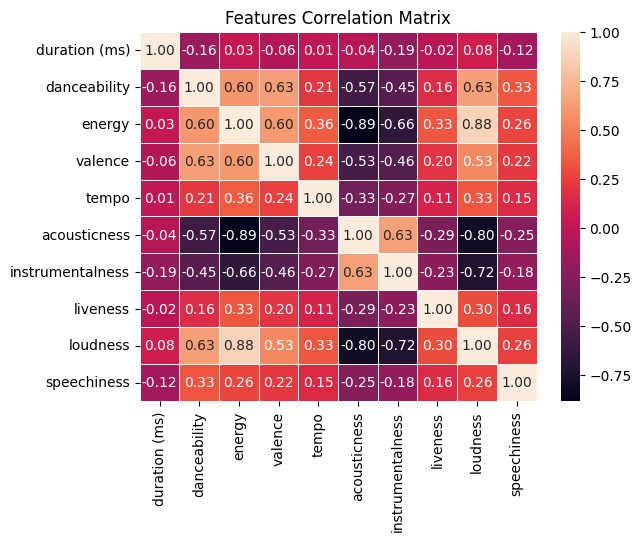

------------------------------------------------------------------------
Data Entries Count Per Label
------------------------------------------------------------------------


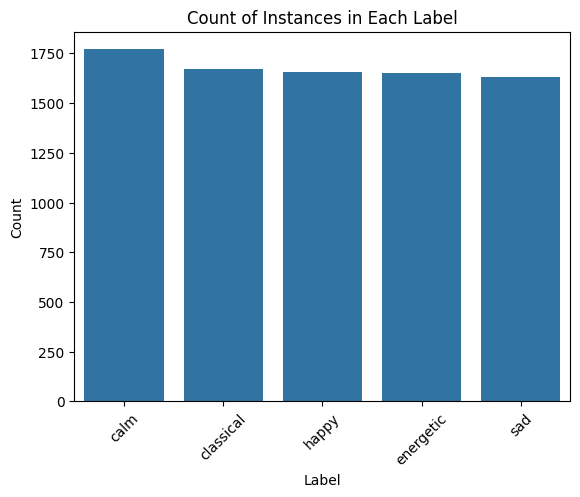

In [ ]:
print('------------------------------------------------------------------------')
print('Heat Map for the features for better understanding on how they correlate to eachother.')
print('------------------------------------------------------------------------')

graph_numerical_features = data.select_dtypes(include=['int64', 'float64'])
if not graph_numerical_features.empty:
    corr_matrix = graph_numerical_features.corr()

    # Plotting the correlation matrix
    plt.figure()
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", linewidths=.5)
    plt.title('Features Correlation Matrix')
    plt.show()
else:
    print("No numerical features available for correlation matrix.")

print('------------------------------------------------------------------------')
print('Data Entries Count Per Label')
print('------------------------------------------------------------------------')

# Plotting the count of instances in each label
label_counts = data.iloc[:, -1].value_counts()  # Assuming last column is 'label'

plt.figure()
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Count of Instances in Each Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


### Data Preprocessing

In [ ]:
# Sample preprocessing
genres_encoded = data['genres'].str.get_dummies(sep=', ')
numerical_features = data.drop(['uri', 'track name', 'artist', 'genres', 'label'], axis=1)
X = pd.concat([numerical_features, genres_encoded], axis=1)
y = data['label'].values

# Encode the labels (targets)
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded = to_categorical(y_encoded)

# Apply SMOTE
smote = SMOTE(random_state=0)
X_smote, y_smote = smote.fit_resample(X, np.argmax(y_encoded, axis=1))
y_smote = to_categorical(y_smote)

# Normalize the features after SMOTE
scaler = MinMaxScaler()
X_scaled_smote = scaler.fit_transform(X_smote)

# Split train and test data with a test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X_scaled_smote, y_smote, test_size=0.2, random_state=0)

# Convert one-hot encoded y_train back to label encoding for class_weight computation
y_train_integers = np.argmax(y_train, axis=1)

# Calculate class weights for the balanced dataset
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_integers),
    y=y_train_integers
)
class_weights_dict = {i : weight for i, weight in enumerate(class_weights)}

### Model Architecture

In [ ]:
# Model creation function
def create_advanced_model():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(512, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.2))
    model.add(Dense(64, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0))
    model.add(Dense(y_train.shape[1], activation='softmax'))

    optimizer = Adam(learning_rate=0.0012, weight_decay=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model



### Model Creation and Visualization

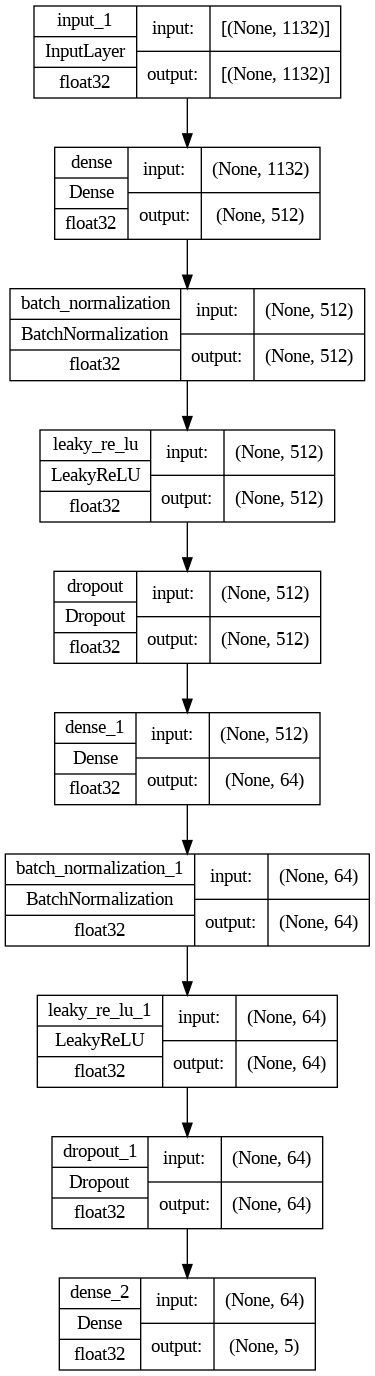

In [ ]:
# Create model
model = create_advanced_model()
plot_model(model, to_file='model_plot2.png', show_shapes=True, show_layer_names=True, expand_nested=True, dpi=96, show_dtype=True)

### Callbacks Creation

In [ ]:

# Callbacks
epochs = 100
early_stopping = EarlyStopping(monitor="val_loss",
    #waiting for the epoch where the validation accuracy is no longer decreasing
    patience=epochs,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights= False,
    start_from_epoch=100,)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.0001)
#model_checkpoint = ModelCheckpoint('best_model_simplified.keras')

### K-folds Cross-Validation and Model Training

In [ ]:
# Define the number of splits
num_folds = 5

# Define KFold cross-validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# Variables to store performance metrics
fold_no = 1
acc_per_fold = []
loss_per_fold = []

for train, test in kfold.split(X_scaled_smote, np.argmax(y_smote, axis=1)):
    # Create a new model for each fold (so the weights are reset)
    model = create_advanced_model()

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    print(f'Training for fold {fold_no}...')
    history = model.fit(
        X_scaled_smote[train], y_smote[train],
        class_weight=class_weights_dict,
        epochs=100,
        batch_size=84,
        verbose=0,
        validation_data=(X_scaled_smote[test], y_smote[test]),
        callbacks=[early_stopping, reduce_lr]
    )

    # Evaluate the model on the validation data
    scores = model.evaluate(X_scaled_smote[test], y_smote[test], verbose=0)

    # Store the results
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase the fold number
    fold_no += 1

Training for fold 1...

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0001.
Score for fold 1: loss of 0.9061650037765503; accuracy of 73.55931997299194%
Training for fold 2...

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0001.
Score for fold 2: loss of 0.9236516952514648; accuracy of 71.97740077972412%
Training for fold 3...

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0001.
Score for fold 3: loss of 0.9310576319694519; accuracy of 72.14689254760742%
Training for fold 4...

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0001.
Score for fold 4: loss of 0.9433026909828186; accuracy of 73.10734391212463%
Training for fold 5...

Epoch 15

### Average Accuracy Scores Per Fold

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.9061650037765503 - Accuracy: 73.55931997299194%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.9236516952514648 - Accuracy: 71.97740077972412%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.9310576319694519 - Accuracy: 72.14689254760742%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.9433026909828186 - Accuracy: 73.10734391212463%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.9255785346031189 - Accuracy: 73.38982820510864%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 72.83615708351135 (+- 0.6504777569410374)
> Loss: 0.925951111316681
-----------------------------

### Model Evaluation and Accuracy Score

In [ ]:
# Evaluation
y_preds = np.argmax(model.predict(X_test), axis=1)
y_test_class = np.argmax(y_test, axis=1)

print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
# Classification report
print(classification_report(y_test_class, y_preds, target_names=encoder.classes_))
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')


# Show the accuracy score
accuracy = accuracy_score(y_test_class, y_preds)
print(f'Test Accuracy: {accuracy*100:.2f}%')
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')

56/56 [==============================] - 0s 6ms/step
------------------------------------------------------------------------
------------------------------------------------------------------------
              precision    recall  f1-score   support

        calm       0.66      0.78      0.71       344
   classical       0.84      0.85      0.85       362
   energetic       0.85      0.82      0.84       350
       happy       0.75      0.73      0.74       355
         sad       0.77      0.69      0.73       359

    accuracy                           0.77      1770
   macro avg       0.78      0.77      0.77      1770
weighted avg       0.78      0.77      0.77      1770

------------------------------------------------------------------------
------------------------------------------------------------------------
Test Accuracy: 77.29%
------------------------------------------------------------------------
-----------------------------------------------------------------------

### Graphs Plotting



*   Heatmap for better understanding the results
*   Model Training Graph



------------------------------------------------------------------------
Heat Map
------------------------------------------------------------------------


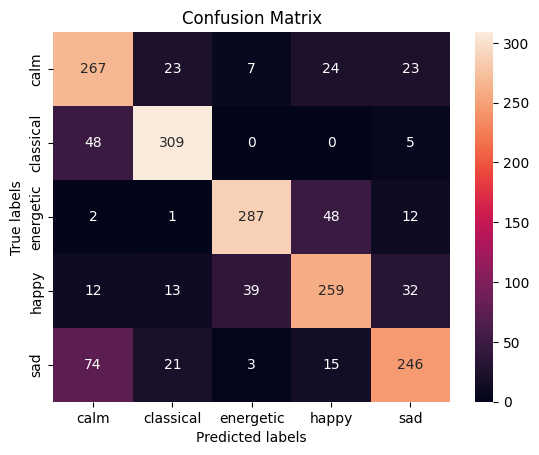

------------------------------------------------------------------------
Training Graph
------------------------------------------------------------------------


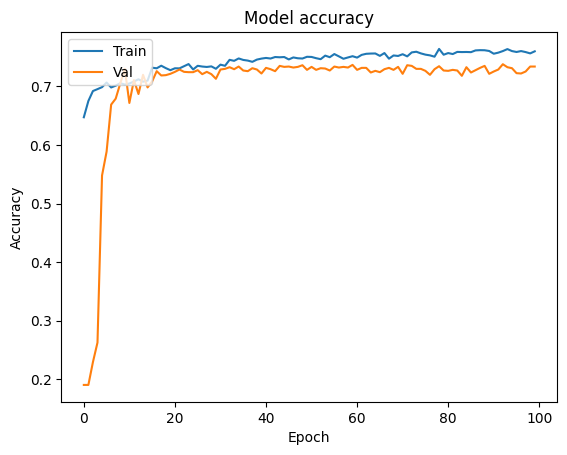

In [ ]:
print('------------------------------------------------------------------------')
print('Heat Map')
print('------------------------------------------------------------------------')
# Create and plot the confusion matrix
cm = confusion_matrix(y_test_class, y_preds)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g')  # 'g' to disable scientific notation
labels = encoder.classes_
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

print('------------------------------------------------------------------------')
print('Training Graph')
print('------------------------------------------------------------------------')

# Plotting training results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


### Saving The Initial Model

In [ ]:
# Save the model and scaler with a new version name
model.save('mood_classification_model_v7.keras')
feature_names = X.columns.tolist()
joblib.dump(feature_names, 'feature_names.pkl')
joblib.dump(scaler, 'scaler_v7.pkl')
joblib.dump(encoder, 'label_encoder.pkl')
print("Model and Scaler v7 saved.")

Model and Scaler v7 saved.


### Model Prediction Test



*   Check the dataset it was trained on

*   Predict the mood of each track

*   Check the predicted mood with the true label
*   Test Model accuracy again


*   Remove the incorrect predictions tracks from the dataset


*   Create a new filtered dataset to train the final Model



In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import joblib

def load_pretrained_components(model_path, scaler_path, encoder_path, feature_names_path):
    """
    Load the pre-trained mood classification model, MinMax scaler, LabelEncoder,
    and the list of feature names.
    """
    model = load_model(model_path)
    scaler = joblib.load(scaler_path)
    encoder = joblib.load(encoder_path)
    feature_names = joblib.load(feature_names_path)
    return model, scaler, encoder, feature_names

def preprocess_playlist_data(playlist_csv_path, scaler, feature_names):
    """
    Load and preprocess the playlist data from a CSV file,
    adjusting the features to match the training dataset.
    """
    playlist_data = pd.read_csv(playlist_csv_path)
    genres_encoded = playlist_data['genres'].str.get_dummies(sep=', ')
    numerical_features = playlist_data.drop(['uri', 'track name', 'artist', 'genres', 'label'], axis=1)
    features = pd.concat([numerical_features, genres_encoded], axis=1)

    missing_cols = {col: 0 for col in feature_names if col not in features.columns}
    features = features.assign(**missing_cols).reindex(columns=feature_names)
    scaled_features = scaler.transform(features)
    return scaled_features

def predict_mood(model, preprocessed_data, encoder):
    """
    Predict the mood for each song in the playlist, returning the mood labels.
    """
    predictions = model.predict(preprocessed_data)
    predicted_indices = np.argmax(predictions, axis=1)
    predicted_moods = encoder.inverse_transform(predicted_indices)
    return predicted_moods

def main(playlist_csv_path, model_path='mood_classification_model_v7.keras', scaler_path='scaler_v7.pkl', encoder_path='label_encoder.pkl', feature_names_path='feature_names.pkl'):
    model, scaler, encoder, feature_names = load_pretrained_components(model_path, scaler_path, encoder_path, feature_names_path)
    preprocessed_data = preprocess_playlist_data(playlist_csv_path, scaler, feature_names)
    predicted_moods = predict_mood(model, preprocessed_data, encoder)

    data = pd.read_csv(playlist_csv_path)
    data['predicted_mood'] = predicted_moods

    # Explicitly defining conditions for new labels
    conditions_for_new_labels = {
        ("happy", "sad"): "bittersweet",
        ("happy", "energetic"): "exuberant",
        ("happy", "calm"): "enjoyment",
        ("happy", "classical"): "mellow",
        ("calm", "sad"): "dazed",
        ("calm", "classical"): "relaxed",
        ("calm", "energetic"): "vibing",
        ("calm", "happy"): "enjoyment",
        ("sad", "classical"): "dramatic",
        ("sad", "energetic"): "restlessness",
        ("sad", "happy"): "bittersweet",
        ("sad", "calm"): "dazed",
        ("classical", "energetic"): "uplifting",
        ("classical", "calm"): "relaxed",
        ("classical", "happy"): "mellow",
        ("classical", "sad"): "dramatic",
        ("energetic", "happy" ): "exuberant",
        ("energetic", "sad"): "restlessness",
        ("energetic", "calm"): "vibing",
        ("energetic", "classical"): "uplifting",
    }

    # Apply conditions to update labels
    for (true_label, predicted_mood), new_label in conditions_for_new_labels.items():
        mask = (data['label'] == true_label) & (data['predicted_mood'] == predicted_mood)
        data.loc[mask, 'label'] = new_label

    # Assuming 'original_labels' contains the list of original labels
    original_labels = ['happy', 'calm', 'sad', 'energetic', 'classical']

    # Filter datasets based on updated labels
    data_with_original_labels = data[data['label'].isin(original_labels)]
    data_with_new_labels = data[~data['label'].isin(original_labels)]

    # Save to CSV
    data_with_original_labels.to_csv('tracks_with_original_labels.csv', index=False)
    data_with_new_labels.to_csv('tracks_with_new_labels.csv', index=False)

    print("Datasets saved: 'tracks_with_new_labels.csv' and 'tracks_with_original_labels.csv'.")

if __name__ == "__main__":
    playlist_csv_path = "shuffled_combined_dataset.csv"  # Adjust this path as needed
    main(playlist_csv_path)


262/262 [==============================] - 1s 4ms/step
Datasets saved: 'tracks_with_new_labels.csv' and 'tracks_with_original_labels.csv'.


# Mood Classfication Model Final


### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, LeakyReLU, GaussianNoise
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l1_l2
from sklearn.model_selection import KFold
from tensorflow.keras import models
from imblearn.over_sampling import SMOTE
import joblib

### Reading Dataset CSV

In [ ]:
# Load dataset
data_original = pd.read_csv('tracks_with_original_labels.csv')
data_new = pd.read_csv('tracks_with_new_labels.csv')

### Plotting Analysis Graphs
* Heatmap for better understanding how features correlate to eachother
* Count of tracks in each label

------------------------------------------------------------------------
Heat Map for the features for better understanding on how they correlate to eachother.
------------------------------------------------------------------------


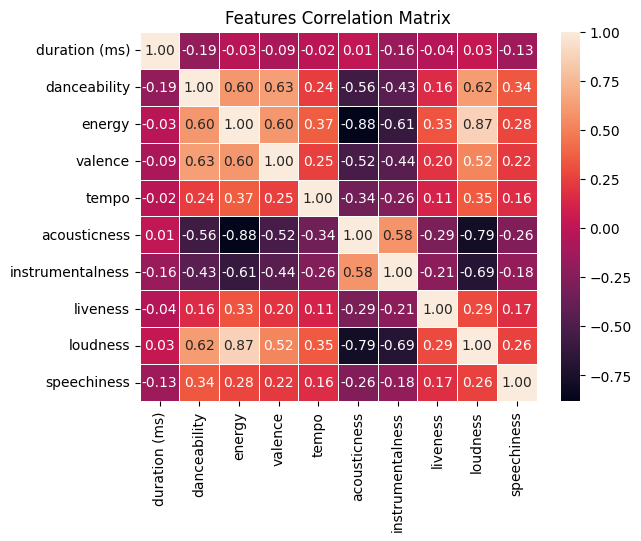

------------------------------------------------------------------------
Data Entries Count Per Label
------------------------------------------------------------------------


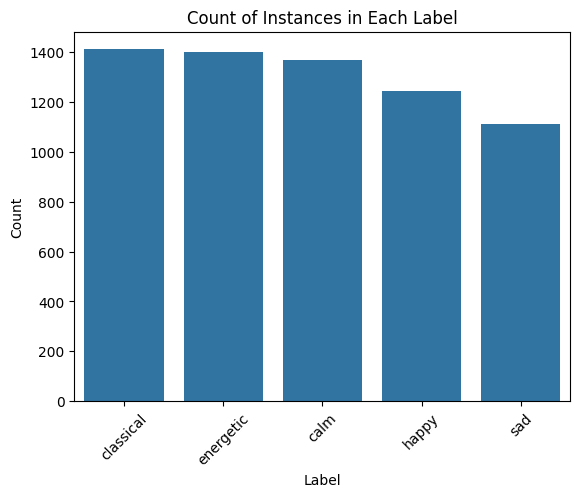

------------------------------------------------------------------------
Heat Map for the features for New Labels
------------------------------------------------------------------------


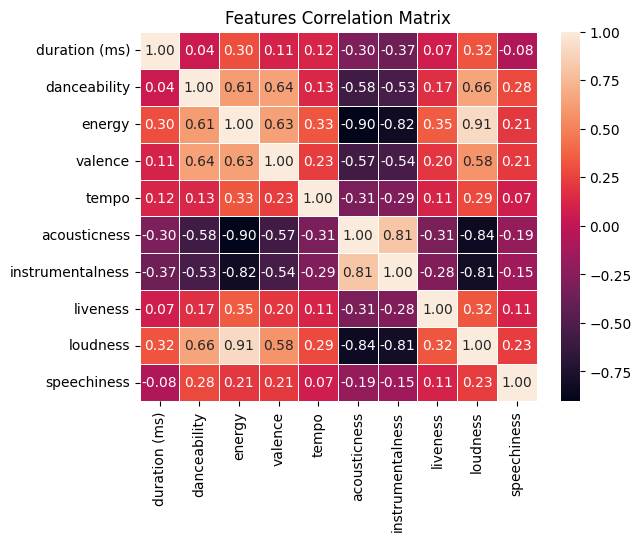

------------------------------------------------------------------------
Data Entries Count Per New Label
------------------------------------------------------------------------


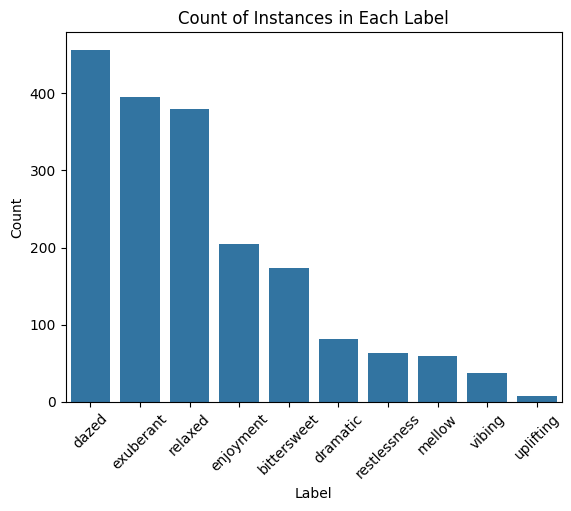

In [ ]:
print('------------------------------------------------------------------------')
print('Heat Map for the features for better understanding on how they correlate to eachother.')
print('------------------------------------------------------------------------')

graph_numerical_features = data_original.select_dtypes(include=['int64', 'float64'])
if not graph_numerical_features.empty:
    corr_matrix = graph_numerical_features.corr()

    # Plotting the correlation matrix
    plt.figure()
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", linewidths=.5)
    plt.title('Features Correlation Matrix')
    plt.show()
else:
    print("No numerical features available for correlation matrix.")

print('------------------------------------------------------------------------')
print('Data Entries Count Per Label')
print('------------------------------------------------------------------------')

# Plotting the count of instances in each label
label_counts = data_original.iloc[:, -2].value_counts()  # Assuming last column is 'label'

plt.figure()
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Count of Instances in Each Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

print('------------------------------------------------------------------------')
print('Heat Map for the features for New Labels')
print('------------------------------------------------------------------------')

graph_numerical_features = data_new.select_dtypes(include=['int64', 'float64'])
if not graph_numerical_features.empty:
    corr_matrix = graph_numerical_features.corr()

    # Plotting the correlation matrix
    plt.figure()
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", linewidths=.5)
    plt.title('Features Correlation Matrix')
    plt.show()
else:
    print("No numerical features available for correlation matrix.")

print('------------------------------------------------------------------------')
print('Data Entries Count Per New Label')
print('------------------------------------------------------------------------')

# Plotting the count of instances in each label
label_counts = data_new.iloc[:, -2].value_counts()  # Assuming last column is 'label'

plt.figure()
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Count of Instances in Each Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


### Data Preprocessing

In [ ]:
# Encode and dummy encode categorical features
genres_encoded = data_original['genres'].str.get_dummies(sep=', ')
genres_encoded_new = data_new['genres'].str.get_dummies(sep=', ')

# Drop non-feature columns and encode labels
features_original = data_original.drop(columns=['uri', 'track name', 'artist', 'genres', 'label', 'predicted_mood'])
features_new = data_new.drop(columns=['uri', 'track name', 'artist', 'genres', 'label', 'predicted_mood'])

# Preprocess features for SMOTE
X_original = pd.concat([features_original, genres_encoded], axis=1)
X_new = pd.concat([features_new, genres_encoded_new], axis=1)


# Split the dataset based on label categories
y_original = data_original['label']
y_new = data_new['label']

# Encode labels
encoder_original = LabelEncoder()
y_original_encoded = encoder_original.fit_transform(y_original)
y_original_encoded = to_categorical(y_original_encoded)

encoder_new = LabelEncoder()
y_new_encoded = encoder_new.fit_transform(y_new)
y_new_encoded = to_categorical(y_new_encoded)


# Apply SMOTE
smote_original = SMOTE(random_state=0)
X_original_smote, y_original_smote = smote_original.fit_resample(X_original, np.argmax(y_original_encoded, axis=1))
y_original_smote = to_categorical(y_original_smote)

# Check for NaN values in X_new
nan_columns = X_new.columns[X_new.isna().any()].tolist()
print(f"Columns with NaN values: {nan_columns}")

# Optionally, get the number of NaN values in each column
nan_counts = X_new[nan_columns].isna().sum()
print(f"NaN counts per column:\n{nan_counts}")

#X_new = X_new.dropna()
#y_new_encoded = np.delete(y_new_encoded, X_new.index[X_new.isna().any(axis=1)], axis=0)

#print(X_new)

smallest_class_size_new = data_new['label'].value_counts().min()
smote_k_neighbors_new = max(smallest_class_size_new - 1, 1)
smote_new = SMOTE(random_state=0, k_neighbors=smote_k_neighbors_new)
#smote_new = SMOTE(random_state=0)
X_new_smote, y_new_smote = smote_new.fit_resample(X_new, np.argmax(y_new_encoded, axis=1))
y_new_smote = to_categorical(y_new_smote)

# Normalize features after SMOTE
original_scaler = MinMaxScaler()
new_scaler = MinMaxScaler()
X_original_scaled = original_scaler.fit_transform(X_original_smote)
X_new_scaled = new_scaler.fit_transform(X_new_smote)

# Split train and test data
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_original_scaled, y_original_smote, test_size=0.2, random_state=0)
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new_scaled, y_new_smote, test_size=0.2, random_state=0)


# Convert one-hot encoded y_train back to label encoding for class_weight computation
y_train_original = np.argmax(y_train_original, axis=1)
y_train_new = np.argmax(y_train_new, axis=1)

# For original labels
class_weights_original = compute_class_weight('balanced', classes=np.unique(y_train_original), y=y_train_original)
class_weights_dict_original = {i : weight for i, weight in enumerate(class_weights_original)}

# For new labels (if applicable)
class_weights_new = compute_class_weight('balanced', classes=np.unique(y_train_new), y=y_train_new)
class_weights_dict_new = {i : weight for i, weight in enumerate(class_weights_new)}

Columns with NaN values: []
NaN counts per column:
Series([], dtype: float64)


### Model Architecture

In [ ]:
def create_advanced_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(512, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.2),
        Dense(64, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0),
        Dense(num_classes, activation='softmax')
    ])
    optimizer = Adam(learning_rate=0.0012, weight_decay=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


### Model Creation and Visualization

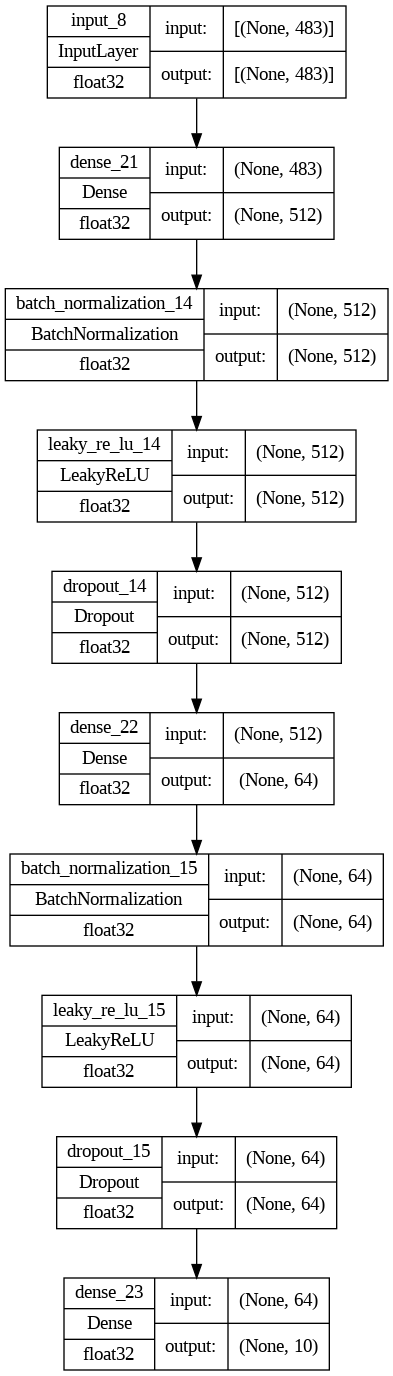

In [ ]:

num_classes_original = len(np.unique(y_train_original))  # Assuming y_train_original is label-encoded
num_classes_new = len(np.unique(y_train_new))  # Assuming y_train_new is label-encoded

# Then create models using these class counts
model_original = create_advanced_model(X_train_original.shape[1], num_classes_original)
model_new = create_advanced_model(X_train_new.shape[1], num_classes_new)

plot_model(model_original, to_file='model_plot2.png', show_shapes=True, show_layer_names=True, expand_nested=True, dpi=96, show_dtype=True)
plot_model(model_new, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True, dpi=96, show_dtype=True)

### Callbacks Creation

In [ ]:

# Callbacks
epochs = 100
early_stopping = EarlyStopping(monitor="val_loss",
    #waiting for the epoch where the validation accuracy is no longer decreasing
    patience=epochs, # You can change it
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights= False,
    start_from_epoch=100,)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.0001)
#model_checkpoint = ModelCheckpoint('best_model_simplified.keras')

### K-folds Cross-Validation and Models Training

**Original Label**

In [ ]:
# Define the number of splits
num_folds = 5


# Define KFold cross-validator for original labels model
kfold_original = KFold(n_splits=num_folds, shuffle=True)

fold_no = 1
acc_per_fold_original = []
loss_per_fold_original = []

for train, test in kfold_original.split(X_original_scaled, np.argmax(y_original_smote, axis=1)):

    model_original = create_advanced_model(X_train_original.shape[1], num_classes_original)  # Create a new model for each fold

    model_original.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # Double-check if y_train_original is one-hot encoded; if not, re-encode it
    #if len(y_train_original.shape) == 1 or y_train_original.shape[1] == 1:  # This means labels are not one-hot encoded
     #   y_train_original = to_categorical(y_train_original)
      #  y_test_original = to_categorical(y_test_original)
    print(f'Training for fold {fold_no}...')
    history_original = model_original.fit(
        X_original_scaled[train], y_original_smote[train],
        class_weight=class_weights_dict_original,  # Use the correct class weights
        epochs=100,
        batch_size=84,
        verbose=0,
        validation_data=(X_original_scaled[train],y_original_smote[train] ),
        callbacks=[early_stopping, reduce_lr]
    )

    scores_original = model_original.evaluate(X_original_scaled[train],y_original_smote[train], verbose=0)
    print(f'Score for fold {fold_no}: loss of {scores_original[0]}; accuracy of {scores_original[1]*100}%')
    acc_per_fold_original.append(scores_original[1] * 100)
    loss_per_fold_original.append(scores_original[0])

    fold_no += 1


Training for fold 1...

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 53: ReduceLROnPlateau reducing learning rate to 0.0001.
Score for fold 1: loss of 0.2934505343437195; accuracy of 98.04826378822327%
Training for fold 2...

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 56: ReduceLROnPlateau reducing learning rate to 0.0001.
Score for fold 2: loss of 0.3067399263381958; accuracy of 97.71113991737366%
Training for fold 3...

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0001.
Score for fold 3: loss of 0.31364598870277405; accuracy of 97.24982380867004%
Training for fold 4...

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 60: ReduceLROnPlateau reducing learning rate to 0.0001.
Score for fold 4: loss of 0.3010600805282593; accuracy of 97.71113991737366%
Training for fold 5...

Epoch 1

**New Label**

In [ ]:
# Reset fold_no for clarity
fold_no = 1

# Variables to store performance metrics for the new labels model
acc_per_fold_new = []
loss_per_fold_new = []

# Define KFold cross-validator for new labels model
kfold_new = KFold(n_splits=num_folds, shuffle=True)

for train, test in kfold_new.split(X_new_scaled, np.argmax(y_new_smote, axis=1)):

    model_new = create_advanced_model(X_train_new.shape[1], num_classes_new)  # Create a new model for each fold

    model_new.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # Double-check if y_train_original is one-hot encoded; if not, re-encode it
    #if len(y_train_original.shape) == 1 or y_train_original.shape[1] == 1:  # This means labels are not one-hot encoded
     #   y_train_original = to_categorical(y_train_original)
      #  y_test_original = to_categorical(y_test_original)
    print(f'Training for fold {fold_no}...')
    history_new = model_new.fit(
        X_new_scaled[train], y_new_smote[train],
        class_weight=class_weights_dict_new,  # Use the correct class weights
        epochs=100,
        batch_size=84,
        verbose=0,
        validation_data=(X_new_scaled[train],y_new_smote[train] ),
        callbacks=[early_stopping, reduce_lr]
    )

    scores_new = model_new.evaluate(X_new_scaled[train],y_new_smote[train], verbose=0)
    print(f'Score for fold {fold_no}: loss of {scores_original[0]}; accuracy of {scores_new[1]*100}%')
    acc_per_fold_new.append(scores_new[1] * 100)
    loss_per_fold_new.append(scores_new[0])

    fold_no += 1



Training for fold 1...

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 63: ReduceLROnPlateau reducing learning rate to 0.0001.
Score for fold 1: loss of 0.29793041944503784; accuracy of 78.97478342056274%
Training for fold 2...

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 76: ReduceLROnPlateau reducing learning rate to 0.0001.
Score for fold 2: loss of 0.29793041944503784; accuracy of 77.98793911933899%
Training for fold 3...

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 55: ReduceLROnPlateau reducing learning rate to 0.0001.
Score for fold 3: loss of 0.29793041944503784; accuracy of 77.38487124443054%
Training for fold 4...

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 53: ReduceLROnPlateau reducing learning rate to 0.0001.
Score for fold 4: loss of 0.29793041944503784; accuracy of 78.61841917037964%
Training for fold 5...

Epoc

### Average Accuracy Scores Per Fold

**Original Label**

In [ ]:
# Providing average scores across all folds for the original labels model
print('------------------------------------------------------------------------')
print('Score per fold (Original Labels)')
for i in range(len(acc_per_fold_original)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} (Original Labels) - Loss: {loss_per_fold_original[i]} - Accuracy: {acc_per_fold_original[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds (Original Labels):')
print(f'> Accuracy: {np.mean(acc_per_fold_original)} (+- {np.std(acc_per_fold_original)})')
print(f'> Loss: {np.mean(loss_per_fold_original)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Score per fold (Original Labels)
------------------------------------------------------------------------
> Fold 1 (Original Labels) - Loss: 0.2934505343437195 - Accuracy: 98.04826378822327%
------------------------------------------------------------------------
> Fold 2 (Original Labels) - Loss: 0.3067399263381958 - Accuracy: 97.71113991737366%
------------------------------------------------------------------------
> Fold 3 (Original Labels) - Loss: 0.31364598870277405 - Accuracy: 97.24982380867004%
------------------------------------------------------------------------
> Fold 4 (Original Labels) - Loss: 0.3010600805282593 - Accuracy: 97.71113991737366%
------------------------------------------------------------------------
> Fold 5 (Original Labels) - Loss: 0.29793041944503784 - Accuracy: 97.97728657722473%
------------------------------------------------------------------------
Average scores for all folds 

**New Label**

In [ ]:
# Providing average scores across all folds for the new labels model
print('------------------------------------------------------------------------')
print('Score per fold (New Labels)')
for i in range(len(acc_per_fold_new)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold_new[i]} - Accuracy: {acc_per_fold_new[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds (New Labels):')
print(f'> Accuracy: {np.mean(acc_per_fold_new)} (+- {np.std(acc_per_fold_new)})')
print(f'> Loss: {np.mean(loss_per_fold_new)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Score per fold (New Labels)
> Fold 1 - Loss: 0.8161590695381165 - Accuracy: 78.97478342056274%
> Fold 2 - Loss: 0.8185936808586121 - Accuracy: 77.98793911933899%
> Fold 3 - Loss: 0.8458291888237 - Accuracy: 77.38487124443054%
> Fold 4 - Loss: 0.8288460969924927 - Accuracy: 78.61841917037964%
> Fold 5 - Loss: 0.8246700167655945 - Accuracy: 77.98793911933899%
------------------------------------------------------------------------
Average scores for all folds (New Labels):
> Accuracy: 78.19079041481018 (+- 0.5530487123197935)
> Loss: 0.8268196105957031
------------------------------------------------------------------------


### Model Evaluation and Accuracy Score

**Original Label**

In [ ]:
# Predictions for the original labels model
y_preds_original = np.argmax(model_original.predict(X_test_original), axis=1)
y_test_class_original = np.argmax(y_test_original, axis=1)

# Classification report for the original labels model
print('------------------------------------------------------------------------')
print('Classification Report (Original Labels)')
print('------------------------------------------------------------------------')
print(classification_report(y_test_class_original, y_preds_original, target_names=encoder_original.classes_))

# Show the accuracy score for the original labels model
accuracy_original = accuracy_score(y_test_class_original, y_preds_original)
print(f'Test Accuracy (Original Labels): {accuracy_original*100:.2f}%')
print('------------------------------------------------------------------------')


45/45 [==============================] - 0s 3ms/step
------------------------------------------------------------------------
Classification Report (Original Labels)
------------------------------------------------------------------------
              precision    recall  f1-score   support

        calm       0.97      1.00      0.98       299
   classical       1.00      0.98      0.99       274
   energetic       0.99      0.97      0.98       289
       happy       0.95      0.95      0.95       261
         sad       0.96      0.97      0.97       286

    accuracy                           0.97      1409
   macro avg       0.97      0.97      0.97      1409
weighted avg       0.97      0.97      0.97      1409

Test Accuracy (Original Labels): 97.30%
------------------------------------------------------------------------


**New Label**

In [ ]:
# Predictions for the new labels model
y_preds_new = np.argmax(model_new.predict(X_test_new), axis=1)
y_test_class_new = np.argmax(y_test_new, axis=1)

# Classification report for the new labels model
print('------------------------------------------------------------------------')
print('Classification Report (New Labels)')
print('------------------------------------------------------------------------')
print(classification_report(y_test_class_new, y_preds_new, target_names=encoder_new.classes_))

# Show the accuracy score for the new labels model
accuracy_new = accuracy_score(y_test_class_new, y_preds_new)
print(f'Test Accuracy (New Labels): {accuracy_new*100:.2f}%')
print('------------------------------------------------------------------------')


29/29 [==============================] - 0s 3ms/step
------------------------------------------------------------------------
Classification Report (New Labels)
------------------------------------------------------------------------
              precision    recall  f1-score   support

 bittersweet       0.77      0.74      0.75        93
       dazed       0.77      0.56      0.65        86
    dramatic       0.83      0.86      0.84        92
   enjoyment       0.81      0.76      0.78        88
   exuberant       0.88      0.74      0.80       104
      mellow       0.83      0.95      0.88        95
     relaxed       0.57      0.59      0.58        87
restlessness       0.68      0.89      0.77        99
   uplifting       0.98      1.00      0.99        89
      vibing       0.81      0.77      0.79        79

    accuracy                           0.79       912
   macro avg       0.79      0.79      0.78       912
weighted avg       0.79      0.79      0.79       912

Test Ac

### Graphs Plotting
* Heatmap for better understanding the results
* Model Training Graph

**Original Label**

------------------------------------------------------------------------
Heat Map (Original Labels)
------------------------------------------------------------------------


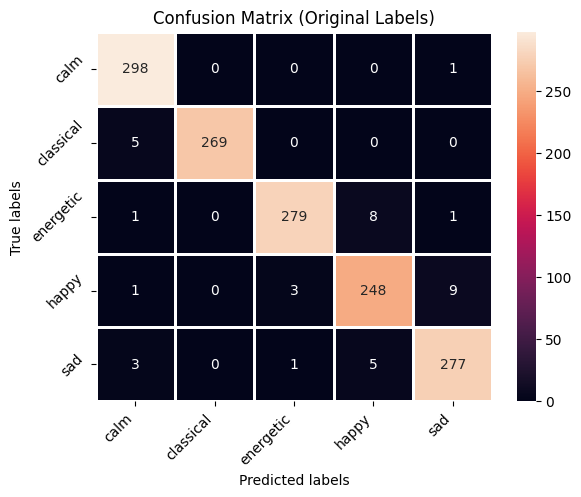

------------------------------------------------------------------------
Training Graph (Original Labels)
------------------------------------------------------------------------


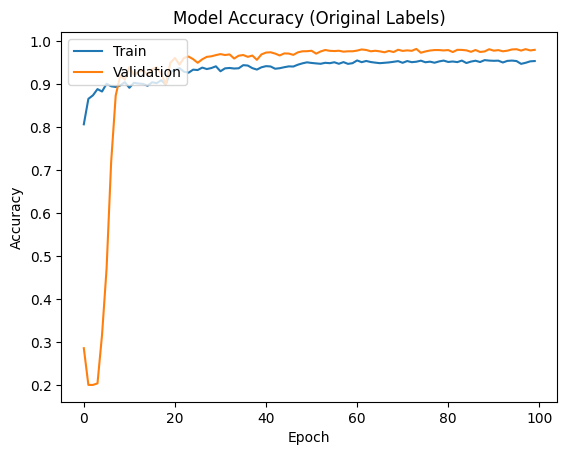

In [ ]:
print('------------------------------------------------------------------------')
print('Heat Map (Original Labels)')
print('------------------------------------------------------------------------')
# Create and plot the confusion matrix for the original labels model
cm_original = confusion_matrix(y_test_class_original, y_preds_original)
ax = plt.subplot()
sns.heatmap(cm_original, annot=True, ax=ax, fmt='g', linewidths=1)
labels_original = encoder_original.classes_
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix (Original Labels)')
ax.xaxis.set_ticklabels(labels_original, rotation=45, ha="right")
ax.yaxis.set_ticklabels(labels_original, rotation=45)
plt.show()


print('------------------------------------------------------------------------')
print('Training Graph (Original Labels)')
print('------------------------------------------------------------------------')
# Plotting training results for the original labels model
plt.plot(history_original.history['accuracy'])
plt.plot(history_original.history['val_accuracy'])
plt.title('Model Accuracy (Original Labels)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



**New Label**

------------------------------------------------------------------------
Heat Map (New Labels)
------------------------------------------------------------------------


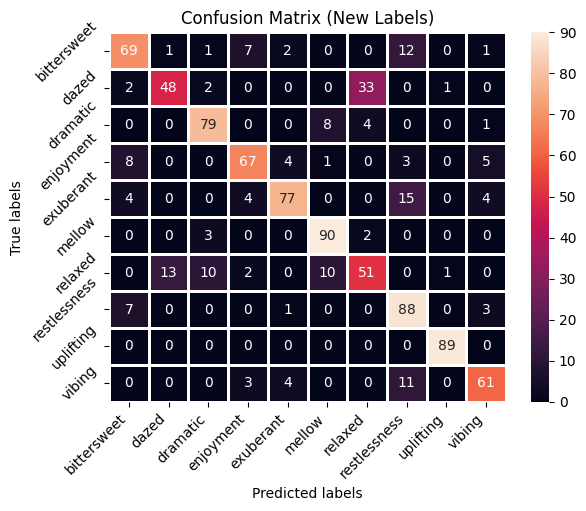

------------------------------------------------------------------------
Training Graph (New Labels)
------------------------------------------------------------------------


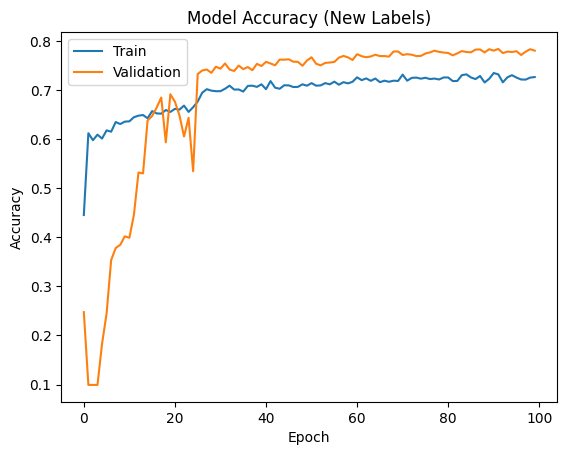

In [ ]:
print('------------------------------------------------------------------------')
print('Heat Map (New Labels)')
print('------------------------------------------------------------------------')
# Create and plot the confusion matrix for the new labels model
cm_new = confusion_matrix(y_test_class_new, y_preds_new)
ax = plt.subplot()
sns.heatmap(cm_new, annot=True, ax=ax, fmt='g', linewidths=1)
labels_new = encoder_new.classes_
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix (New Labels)')
ax.xaxis.set_ticklabels(labels_new, rotation=45, ha="right")
ax.yaxis.set_ticklabels(labels_new, rotation=45)
plt.show()

print('------------------------------------------------------------------------')
print('Training Graph (New Labels)')
print('------------------------------------------------------------------------')
# Plotting training results for the new labels model
plt.plot(history_new.history['accuracy'])
plt.plot(history_new.history['val_accuracy'])
plt.title('Model Accuracy (New Labels)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


### Saving The Final Models

In [ ]:
# Save the original model and its components
model_original.save('original_mood_classification_model.keras')
joblib.dump(original_scaler, 'original_scaler.pkl')  # Assuming the same scaler is used for both models; adjust if not
joblib.dump(encoder_original, 'original_label_encoder.pkl')

# If 'X' is from the original dataset before splitting
feature_names_original = X_original.columns.tolist()  # Adjust 'X' if necessary to reflect the original features used
joblib.dump(feature_names_original, 'original_feature_names.pkl')

print("Original Model, Scaler, Features, and Encoder saved.")


Original Model, Scaler, Features, and Encoder saved.


In [ ]:
# Save the new model and its components
model_new.save('new_mood_classification_model.keras')
joblib.dump(new_scaler, 'new_scaler.pkl')  # Assuming the same scaler is used for both models; adjust if not
joblib.dump(encoder_new, 'new_label_encoder.pkl')

# If 'X_new' represents the features matrix after preprocessing for the new dataset
feature_names_new = X_new.columns.tolist()  # Adjust 'X_new' to the correct variable name if necessary
joblib.dump(feature_names_new, 'new_feature_names.pkl')

print("New Model, Scaler, Features, and Encoder saved.")


New Model, Scaler, Features, and Encoder saved.


#Mood Prediction For Activity Playlists

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

def load_pretrained_components(original_model_path, new_model_path, original_scaler_path, new_scaler_path, original_encoder_path, new_encoder_path, original_feature_names_path, new_feature_names_path):
    original_model = load_model(original_model_path)
    new_model = load_model(new_model_path)
    original_scaler = joblib.load(original_scaler_path)
    new_scaler = joblib.load(new_scaler_path)
    original_encoder = joblib.load(original_encoder_path)
    new_encoder = joblib.load(new_encoder_path)
    original_feature_names = joblib.load(original_feature_names_path)
    new_feature_names = joblib.load(new_feature_names_path)
    return original_model, new_model, original_scaler, new_scaler, original_encoder, new_encoder, original_feature_names, new_feature_names

def preprocess_playlist_data(playlist_csv_path, original_scaler, new_scaler, original_feature_names, new_feature_names):
    playlist_data = pd.read_csv(playlist_csv_path)
    genres_encoded = playlist_data['genres'].str.get_dummies(sep=', ')

    numerical_features = playlist_data.drop(['uri', 'track name', 'artist', 'genres', 'count'], axis=1)
    features = pd.concat([numerical_features, genres_encoded], axis=1)

    # Handle Original Features
    # Align the features DataFrame with the original features the model was trained on
    # Missing original genres/features will be left as NaN
    features_original = features.reindex(columns=original_feature_names)
    print("Missing features in original:", set(original_feature_names) - set(features.columns))
    print("Extra features in original:", set(features.columns) - set(original_feature_names))

    # Scale the original features, filling NaN values with 0s
    scaled_features_original = original_scaler.transform(features_original.fillna(0))

    # Handle New Features
    # Align the features DataFrame with the new features the model was trained on
    # Missing new genres/features will be left as NaN
    features_new = features.reindex(columns=new_feature_names)
    print("Missing features in new:", set(new_feature_names) - set(features.columns))
    print("Extra features in new:", set(features.columns) - set(new_feature_names))

    # Scale the new features, filling NaN values with 0s
    scaled_features_new = new_scaler.transform(features_new.fillna(0))

    return scaled_features_original, scaled_features_new

def combined_prediction(original_model, new_model, original_preprocessed_data, new_preprocessed_data, original_encoder, new_encoder):
    original_predictions = original_model.predict(original_preprocessed_data)
    new_predictions = new_model.predict(new_preprocessed_data)
    combined_predictions = []

    for orig_pred, new_pred in zip(original_predictions, new_predictions):
        if max(orig_pred) > max(new_pred):
            combined_predictions.append(np.argmax(orig_pred))
        else:
            combined_predictions.append(np.argmax(new_pred) + len(original_encoder.classes_))

    decoded_predictions = [original_encoder.classes_[i] if i < len(original_encoder.classes_) else new_encoder.classes_[i - len(original_encoder.classes_)] for i in combined_predictions]
    return decoded_predictions

def analyze_mood_distribution(predicted_moods):
    mood_counts = pd.Series(predicted_moods).value_counts(normalize=True) * 100
    return mood_counts

def main(playlist_csv_path):
    original_model, new_model, original_scaler, new_scaler, original_encoder, new_encoder, original_feature_names, new_feature_names = load_pretrained_components(
        'original_mood_classification_model.keras',
        'new_mood_classification_model.keras',
        'original_scaler.pkl',
        'new_scaler.pkl',
        'original_label_encoder.pkl',
        'new_label_encoder.pkl',
        'original_feature_names.pkl',
        'new_feature_names.pkl'
    )

    original_preprocessed, new_preprocessed = preprocess_playlist_data(playlist_csv_path, original_scaler, new_scaler, original_feature_names, new_feature_names)
    combined_preds = combined_prediction(original_model, new_model, original_preprocessed, new_preprocessed, original_encoder, new_encoder)
    mood_distribution = analyze_mood_distribution(combined_preds)

    print("\nCombined Mood Distribution in the Playlist:")
    for mood, percentage in mood_distribution.items():
        print(f"{mood}: {percentage:.2f}%")

    data = pd.read_csv(playlist_csv_path)  # Assuming this is the correct path to your dataset
    if len(data) == len(combined_preds):
        data['Predicted Mood'] = combined_preds
        new_csv_path = playlist_csv_path.replace('.csv', '_with_predictions.csv')
        data.to_csv(new_csv_path, index=False)
        print(f"Updated playlist with predictions saved to: {new_csv_path}")
    else:
        print("Error: The number of predictions does not match the number of tracks in the playlist.")


    #actual_labels = data['label'].values
    #accuracy = accuracy_score(actual_labels, combined_preds)
    #print(f"\nModel Accuracy: {accuracy * 100:.2f}%")

if __name__ == "__main__":
    playlist_csv_path = "prepared_tracklist.csv"  # Adjust this path to your dataset
    main(playlist_csv_path)


# Recommendations


### Preparing Data For Mood Prediction

In [ ]:
import pandas as pd

def prepare_data_for_mood_prediction(csv_path, columns_to_keep):
    """
    Keeps only specified columns in a CSV file and optionally keeps the 'Count' column if it exists.
    Saves the modified dataset back to the original file location.

    Parameters:
    - csv_path: The path to the CSV file.
    - columns_to_keep: A list of column names to keep in the CSV file.
    """
    # Load the CSV file
    data = pd.read_csv(csv_path)

    # Automatically determine if 'Count' column exists and should be kept
    if 'count' in data.columns and 'count' not in columns_to_keep:
        columns_to_keep.append('count')

    # Determine which columns to drop by excluding the columns to keep
    columns_to_drop = [col for col in data.columns if col not in columns_to_keep]

    # Drop the unnecessary columns
    data = data.drop(columns=columns_to_drop, errors='ignore')

    # Drop duplicate rows based on 'uri'
    data = data.drop_duplicates(subset=['uri'])

    # Save the modified DataFrame back to the original CSV file
    data.to_csv(csv_path, index=False)

    print(f"Modified CSV saved. Kept columns: {columns_to_keep}")


    # Save the prepared data
    prepared_csv_path = 'prepared_tracklist.csv'
    data.to_csv(prepared_csv_path, index=False)

    return prepared_csv_path

# Define columns to keep outside of the function call
columns_to_keep = [
  'uri', 'track name', 'artist', 'duration (ms)', 'genres',
            'danceability', 'energy', 'valence', 'tempo', 'acousticness',
            'instrumentalness', 'liveness', 'loudness', 'speechiness'
]
# Example usage
if __name__ == "__main__":

    csv_path = "Cooking.csv"  # Adjust this path to your dataset
    prepare_data_for_mood_prediction(csv_path, columns_to_keep)


Modified CSV saved. Kept columns: ['uri', 'track name', 'artist', 'duration (ms)', 'genres', 'danceability', 'energy', 'valence', 'tempo', 'acousticness', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'count']


###Mood Prediction For Activity Playlists

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

def load_pretrained_components(original_model_path, new_model_path, original_scaler_path, new_scaler_path, original_encoder_path, new_encoder_path, original_feature_names_path, new_feature_names_path):
    original_model = load_model(original_model_path)
    new_model = load_model(new_model_path)
    original_scaler = joblib.load(original_scaler_path)
    new_scaler = joblib.load(new_scaler_path)
    original_encoder = joblib.load(original_encoder_path)
    new_encoder = joblib.load(new_encoder_path)
    original_feature_names = joblib.load(original_feature_names_path)
    new_feature_names = joblib.load(new_feature_names_path)
    return original_model, new_model, original_scaler, new_scaler, original_encoder, new_encoder, original_feature_names, new_feature_names

def preprocess_playlist_data(playlist_csv_path, original_scaler, new_scaler, original_feature_names, new_feature_names):
    playlist_data = pd.read_csv(playlist_csv_path)
    genres_encoded = playlist_data['genres'].str.get_dummies(sep=', ')

    numerical_features = playlist_data.drop(['uri', 'track name', 'artist', 'genres', 'count'], axis=1)
    features = pd.concat([numerical_features, genres_encoded], axis=1)

    # Handle Original Features
    # Align the features DataFrame with the original features the model was trained on
    # Missing original genres/features will be left as NaN
    features_original = features.reindex(columns=original_feature_names)
    print("Missing features in original:", set(original_feature_names) - set(features.columns))
    print("Extra features in original:", set(features.columns) - set(original_feature_names))

    # Scale the original features, filling NaN values with 0s
    scaled_features_original = original_scaler.transform(features_original.fillna(0))

    # Handle New Features
    # Align the features DataFrame with the new features the model was trained on
    # Missing new genres/features will be left as NaN
    features_new = features.reindex(columns=new_feature_names)
    print("Missing features in new:", set(new_feature_names) - set(features.columns))
    print("Extra features in new:", set(features.columns) - set(new_feature_names))

    # Scale the new features, filling NaN values with 0s
    scaled_features_new = new_scaler.transform(features_new.fillna(0))

    return scaled_features_original, scaled_features_new

def combined_prediction(original_model, new_model, original_preprocessed_data, new_preprocessed_data, original_encoder, new_encoder):
    original_predictions = original_model.predict(original_preprocessed_data)
    new_predictions = new_model.predict(new_preprocessed_data)
    combined_predictions = []

    for orig_pred, new_pred in zip(original_predictions, new_predictions):
        if max(orig_pred) > max(new_pred):
            combined_predictions.append(np.argmax(orig_pred))
        else:
            combined_predictions.append(np.argmax(new_pred) + len(original_encoder.classes_))

    decoded_predictions = [original_encoder.classes_[i] if i < len(original_encoder.classes_) else new_encoder.classes_[i - len(original_encoder.classes_)] for i in combined_predictions]
    return decoded_predictions

def analyze_mood_distribution(predicted_moods):
    mood_counts = pd.Series(predicted_moods).value_counts(normalize=True) * 100
    return mood_counts

def main(playlist_csv_path):
    original_model, new_model, original_scaler, new_scaler, original_encoder, new_encoder, original_feature_names, new_feature_names = load_pretrained_components(
        'original_mood_classification_model.keras',
        'new_mood_classification_model.keras',
        'original_scaler.pkl',
        'new_scaler.pkl',
        'original_label_encoder.pkl',
        'new_label_encoder.pkl',
        'original_feature_names.pkl',
        'new_feature_names.pkl'
    )

    original_preprocessed, new_preprocessed = preprocess_playlist_data(playlist_csv_path, original_scaler, new_scaler, original_feature_names, new_feature_names)
    combined_preds = combined_prediction(original_model, new_model, original_preprocessed, new_preprocessed, original_encoder, new_encoder)
    mood_distribution = analyze_mood_distribution(combined_preds)

    print("\nCombined Mood Distribution in the Playlist:")
    for mood, percentage in mood_distribution.items():
        print(f"{mood}: {percentage:.2f}%")

    data = pd.read_csv(playlist_csv_path)  # Assuming this is the correct path to your dataset
    if len(data) == len(combined_preds):
        data['Predicted Mood'] = combined_preds
        new_csv_path = playlist_csv_path.replace('.csv', '_with_predictions.csv')
        data.to_csv(new_csv_path, index=False)
        print(f"Updated playlist with predictions saved to: {new_csv_path}")
    else:
        print("Error: The number of predictions does not match the number of tracks in the playlist.")


    #actual_labels = data['label'].values
    #accuracy = accuracy_score(actual_labels, combined_preds)
    #print(f"\nModel Accuracy: {accuracy * 100:.2f}%")

if __name__ == "__main__":
    playlist_csv_path = "prepared_tracklist.csv"  # Adjust this path to your dataset
    main(playlist_csv_path)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Missing features in original: {'mecha', '2-step', 'pop edm', 'circuit', 'piano rock', 'acoustic pop', 'minimal techno', 'blues rock', 'toronto indie', 'soul', 'sheffield indie', 'indie garage rock', 'afrobeats', 'nu metal', 'afroswing', 'french contemporary classical', 'modern country rock', 'canadian country', 'post-minimalism', 'birmingham metal', 'psychedelic pop', 'modern jazz piano', 'deep disco house', 'swedish garage rock', 'dutch indie', 'anime phonk', 'classic arab pop', 'afrobeat', 'german soundtrack', 'french synthpop', 'chill r&b', 'israeli indie', 'nottingham indie', 'big room', "women's choir", 'orchestral performance', 'mashup', 'aesthetic rap', 'chill house', 'modern blues rock', 'ukrainian classical piano', 'louisiana blues', 'scottish rock', 'indie anthem-folk', 'new orleans rap', 'baton rouge rap', 'fourth world', 'nu jazz', 'string orchestra', 'contemporary classical', 'french indietronica', 'experimental folk', 'irish indie', 'rochester mn indie', 'classic rock', '



### Calculating Features Average and Target Feautres

In [ ]:
import pandas as pd

def aggregate_features_by_mood(csv_path):
    data = pd.read_csv(csv_path)
    mood_groups = data.groupby('Predicted Mood')

    aggregated_data = {}
    for mood, group in mood_groups:
        mean_features = group[['danceability', 'energy', 'valence', 'tempo', 'acousticness',
                               'instrumentalness', 'liveness', 'loudness', 'speechiness']].mean().to_dict()

        # Calculate minimum and maximum features
        min_max_features = group[['danceability', 'energy', 'valence', 'tempo', 'acousticness',
                                   'instrumentalness', 'liveness', 'loudness', 'speechiness']].agg(['min', 'max']).to_dict()

        aggregated_data[mood] = {'min_max_features': min_max_features}

        if 'count' in data.columns:
          target_song = group.loc[group['count'].idxmax()]
          target_features = target_song[['danceability', 'energy', 'valence', 'tempo', 'acousticness',
                                       'instrumentalness', 'liveness', 'loudness', 'speechiness']].to_dict()

          aggregated_data[mood] = {'min_max_features': min_max_features, 'target_features': target_features}

    return aggregated_data

# Example usage
prepared_csv_path = 'prepared_tracklist_with_predictions.csv'
aggregated_data = aggregate_features_by_mood(prepared_csv_path)

print(aggregated_data)


{'calm': {'min_max_features': {'danceability': {'min': 0.472, 'max': 0.706}, 'energy': {'min': 0.137, 'max': 0.268}, 'valence': {'min': 0.0641, 'max': 0.345}, 'tempo': {'min': 126.144, 'max': 130.082}, 'acousticness': {'min': 0.806, 'max': 0.85}, 'instrumentalness': {'min': 0.875, 'max': 0.907}, 'liveness': {'min': 0.106, 'max': 0.11}, 'loudness': {'min': -13.205, 'max': -8.406}, 'speechiness': {'min': 0.0349, 'max': 0.0374}}, 'target_features': {'danceability': 0.472, 'energy': 0.137, 'valence': 0.0641, 'tempo': 126.144, 'acousticness': 0.85, 'instrumentalness': 0.907, 'liveness': 0.11, 'loudness': -13.205, 'speechiness': 0.0349}}, 'classical': {'min_max_features': {'danceability': {'min': 0.194, 'max': 0.484}, 'energy': {'min': 0.0139, 'max': 0.344}, 'valence': {'min': 0.057, 'max': 0.802}, 'tempo': {'min': 66.718, 'max': 137.274}, 'acousticness': {'min': 0.81, 'max': 0.988}, 'instrumentalness': {'min': 0.776, 'max': 0.957}, 'liveness': {'min': 0.0682, 'max': 0.15}, 'loudness': {'min

### Calculating The Number Of Tracks Per Each Mood

In [ ]:
import pandas as pd

def count_tracks_by_mood(csv_path):
    # Load the dataset
    data = pd.read_csv(csv_path)

    # Ensure the 'PredictedMood' column exists
    if 'Predicted Mood' not in data.columns:
        raise ValueError("The CSV file does not contain a 'Predicted Mood' column.")

    # Count the number of tracks for each predicted mood
    mood_counts = data['Predicted Mood'].value_counts()

    return mood_counts.to_dict()

# Example usage
csv_path = 'prepared_tracklist_with_predictions.csv'  # Make sure to use the path to your actual CSV file
tracks_by_mood = count_tracks_by_mood(csv_path)
print(tracks_by_mood)


{'classical': 21, 'energetic': 2, 'calm': 2}


### Get Track ID Per Mood

In [ ]:

import pandas as pd

def get_highest_count_track_ids(csv_path):
    """
    Extracts track IDs with the highest counts (if available) or the first 3 track IDs
    for each predicted mood from a CSV file.

    Args:
        csv_path (str): The path to the CSV file.

    Returns:
        dict: A dictionary where keys are predicted moods and values are lists of track IDs
              (without the 'spotify:track:' prefix).
    """

    df = pd.read_csv(csv_path)

    mood_track_id_dict = {}
    for mood_col in df.columns:
        if mood_col == 'Predicted Mood':
            for mood_name in df[mood_col].unique():
                filtered_df = df.loc[df[mood_col] == mood_name]
                if 'count' in df.columns:
                    # If 'count' exists, get tracks with highest counts
                    max_count_tracks = filtered_df.sort_values(by='count', ascending=False).head(3)
                    track_ids = max_count_tracks['uri'].str.replace('spotify:track:', '').tolist()
                else:
                    # If 'count' doesn't exist, get the first 3 tracks
                    track_ids = filtered_df['uri'].str.replace('spotify:track:', '').tolist()[:3]
                mood_track_id_dict[mood_name] = track_ids

    return mood_track_id_dict
csv_path = 'prepared_tracklist_with_predictions.csv'
track_id_dict = get_highest_count_track_ids(csv_path)
print(track_id_dict)


{'classical': ['05UMQXFCsa9oPnLgfJHVyF', '3GWjgMk7yLcLBQnudEETEi', '70o2ksjh5WHKuk7jSDzQcm'], 'energetic': ['0fxA0BtG1MzGvcQUrtG4zy', '0kdqcbwei4MDWFEX5f33yG'], 'calm': ['3krXHfpVItTM0L9xIKefcM', '4zdrzRrjaEYAQAVQMSENgO']}


### Get Recommendations and Playlist Creation in Spotfiy Account



**Reccomendations for Activity Playlists**

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

# Your Spotify API credentials
CLIENT_ID =
CLIENT_SECRET =
REDIRECT_URI =
open_browser=False
SCOPE = "user-library-read playlist-modify-public"

# Authenticate with Spotify
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=CLIENT_ID, client_secret=CLIENT_SECRET, redirect_uri=REDIRECT_URI, scope=SCOPE,open_browser=False))


def get_spotify_recommendations_recent(aggregated_data, tracks_by_mood, use_count):
    """
    Fetch Spotify recommendations based on aggregated data.

    :param aggregated_data: Dictionary containing mean and target features for each mood.
    :param tracks_by_mood: Dictionary with the count of tracks for each mood.
    :param use_count: Boolean indicating whether to use the 'count' feature or not.
    :return: Dictionary of recommendations for each mood.
    """
    recommendations = {}

    for mood, data in aggregated_data.items():
        limit = tracks_by_mood.get(mood, 1)  # Default to 1 if the mood is not in tracks_by_mood
        seed_tracks = track_id_dict.get(mood,[])
        # Prepare the attributes for the recommendation query
        target_attributes = {}
        if use_count == True:
            target_attributes = {f"target_{key}": value for key, value in data['target_features'].items()}
        else:
            for feature, values in data['min_max_features'].items():
              target_attributes[f"min_{feature}"] = values['min']
              target_attributes[f"max_{feature}"] = values['max']

        # Fetch recommendations from Spotify
        try:
            recs = sp.recommendations(seed_tracks=seed_tracks,limit=limit, **target_attributes)
            recommendations[mood] = [track['id'] for track in recs['tracks']]
        except Exception as e:
            print(f"Error fetching recommendations for mood {mood}: {e}")
            recommendations[mood] = []

    return recommendations

# Example usage:
# Make sure to replace 'aggregated_data' and 'tracks_by_mood' with your actual data
#aggregated_data
csv_path = 'prepared_tracklist_with_predictions.csv'  # Make sure to use the path to your actual CSV file
tracks_by_mood = count_tracks_by_mood(csv_path)
track_id_dict = get_highest_count_track_ids(csv_path)
recommendations = get_spotify_recommendations_recent(aggregated_data, tracks_by_mood, use_count=False)
print(recommendations)


Go to the following URL: https://accounts.spotify.com/authorize?client_id=7dd96ee0081244e1996bc7736dd68b95&response_type=code&redirect_uri=https%3A%2F%2Flocalhost%3A8888%2Fcallback&scope=user-library-read+playlist-modify-public
Enter the URL you were redirected to: https://localhost:8888/callback?code=AQDgPHI0RvhDJVPBU81S97M9sOb8rsLWokH6XXiptv0VbYUGpDMoX3su4yCmP__4Fes8g5UKTD_rM_BPdMsNldbePipUSXSftBVX67jz3SPDl0PUtk_3UfbadUUpSHUbt9ZKg7g78DVKq5SMeNbqgRAJ3SeaX3Qrcc2AEQ4R13-Ds_nzIxtlnKGBAnEFw2EubWncJnbUzTu2fQduUzl_xv0_aYs9O5Bz_sn6Hn_M
{'calm': ['3krXHfpVItTM0L9xIKefcM', '4zdrzRrjaEYAQAVQMSENgO'], 'classical': ['4HBGaiBz5jIN3qwf6xACmH', '2a3xqamzGaJcwT15r8yGUL', '5zCFSRhUyORe1iwlOv4fsU', '0t6LQNivrcogRLbv0PoUsT', '2GR6j331Qe1bUbDZTkZEKa', '2yhxvZQ1Fl6AbZeyS9I5mc', '6nCTNJkW1M9ISMnrCxYlbo', '025MCO77mnKj0rKqCo1GU1', '0NsG1b9koK74vTJ2VJUJQU', '3Hsbgq0UmDGkTsXXpBMp4H', '0GItNiM65Sa2KsEBeQe4zv', '3MquQbSlkq5ioqHsVkLb3J', '33Rc0lbQc5w45w9ASaG9oP', '1jjzAwipTGhp2T1MiB9fBa', '1zUVPvm0osbOqRuV23iyXS

### Playlist Creation

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth


def create_playlist(playlist_name, track_uris):
    """
    Creates a Spotify playlist with the given name and adds the specified tracks.

    Args:
        playlist_name (str): The name of the playlist to create.
        track_uris (list): A list of track URIs to add to the playlist.
    """

    # Get the current user's ID
    user_id = sp.current_user()['id']

    # Create the playlist
    playlist = sp.user_playlist_create(user_id, playlist_name)

    # Add tracks to the playlist
    sp.playlist_add_items(playlist['id'], track_uris)

# Example usage:
csv_path = 'prepared_tracklist_with_predictions.csv'
track_id_dict = get_highest_count_track_ids(csv_path)
recommendations = get_spotify_recommendations_recent(aggregated_data, tracks_by_mood, use_count=True)
print(recommendations)


# Combine recommended track IDs and track URIs from CSV
all_track_uris = []
for mood, track_ids in recommendations.items():
  all_track_uris.extend(track_ids)  # Add recommended track IDs

# Add track URIs from CSV (assuming 'uri' column contains URIs)
df = pd.read_csv(csv_path)
all_track_uris.extend(df['uri'].tolist())

# Create the playlist (replace 'My Awesome Playlist' with your desired name)
create_playlist('Cooking Playlist', all_track_uris)

{'calm': ['2LjESumGwJn0Npd8hYtGEv', '4Li0YRgjKpY470p2cUONCs'], 'classical': ['6PBzpqQmlZ8Ps4dko9G31t', '05UMQXFCsa9oPnLgfJHVyF', '2UQ6szguWAUi9jib60mapd', '5T7DUEeAj0hkMLTzIlDCRz', '2Ggw6Fz6Uc9SQHWx1aNcwz', '4wBXEpgnkXMPXkCUGbIQRz', '1OHYPm2iuP9N6rHjO32MiC', '62Da3JOu9H9EIgmqV7DoLG', '2GwtgkuOvbRVRph8Gn3fjD', '5D6qyBs2hIZExANKGnBaxI', '0VdLdLzi1cxn0ifmwiP0vC', '4IRtGM0KT7lYYHykCfUfC6', '2RZHKpTUL6QfHGrjCwk5dd', '4ruglKUpAn9zt6CUlx2jcl', '2ol3vqH45ROqozQQ57kP9x', '2MaUwANhrU6KF8AK71ezsX', '3jPH5thjHvMXsbB7GxD2zI', '58xaK6IIy8eFKPuPRmFR53', '5w2QOKYxCH10IcZVh9XJYz', '3wNSZ0ZowXgUeO4sEEHMRw', '0DOQ9U9j374KJ5JVZRF44u'], 'energetic': ['3z6X1pQSGdky5rQADTLM2g', '0fxA0BtG1MzGvcQUrtG4zy']}


#Evaluation

### Download Files from Drive

In [ ]:

from google.colab import drive
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io
import os
from datetime import datetime

def download_files_in_folder(folder_id):
    """Downloads files within a specific folder from Google Drive and saves them directly in Colab."""
    service = build('drive', 'v3')

    results = service.files().list(
        q=f"'{folder_id}' in parents",
        fields="nextPageToken, files(id, name)").execute()

    items = results.get('files', [])

    for item in items:
        file_id = item['id']
        filename = item['name']

        # Download file directly and save in Colab environment
        request = service.files().get_media(fileId=file_id)
        fh = io.BytesIO()
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while done is False:
            status, done = downloader.next_chunk()
        fh.seek(0)
        with open(filename, 'wb') as f:  # Save directly using filename
            f.write(fh.read())
        print(f'Downloaded {filename}')

# Example usage:
folder_id = ''  # Replace with your folder ID
from google.colab import auth
auth.authenticate_user()

download_files_in_folder(folder_id)



Downloaded walking_recommended_playlist.csv
Downloaded for_me_spotify_playlits.csv
Downloaded cooking_recommended_playlist.csv
Downloaded chilling_recommended_playlist.csv
Downloaded mood_classification_model_v7.keras
Downloaded scaler_v7.pkl
Downloaded label_encoder.pkl
Downloaded Cooking.csv
Downloaded walking.csv
Downloaded chilling.csv
Downloaded complete_tracklist_with_genres.csv
Downloaded original_scaler.pkl
Downloaded original_mood_classification_model.keras
Downloaded original_label_encoder.pkl
Downloaded original_feature_names.pkl
Downloaded new_scaler.pkl
Downloaded new_mood_classification_model.keras
Downloaded new_label_encoder.pkl
Downloaded new_feature_names.pkl
Downloaded feature_names.pkl
Downloaded tracks_with_original_labels.csv
Downloaded tracks_with_new_labels.csv
Downloaded shuffled_combined_dataset (1).csv
Downloaded sad.csv
Downloaded happy.csv
Downloaded energetic.csv
Downloaded classical.csv
Downloaded calm.csv


### Download Recommended Playlists

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd
import time
from requests.exceptions import Timeout

# Your Spotify API credentials
SCOPE = 'playlist-read-private'
CLIENT_ID =
CLIENT_SECRET =
REDIRECT_URI =

print("Starting authentication...")
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=CLIENT_ID,
                                               client_secret=CLIENT_SECRET,
                                               redirect_uri=REDIRECT_URI,
                                               scope=SCOPE,
                                               open_browser=False))
print("Authentication successful.")

# Set a timeout for all requests made through the Spotify client
sp._session.timeout = 10  # 10-second timeout

def safe_spotify_call(callable, *args, **kwargs):
    """Safe wrapper for Spotify API calls with retry logic for handling rate limits and timeouts."""
    max_retries = 5
    retries = 0
    while retries < max_retries:
        try:
            print(f"Making Spotify API call to {callable.__name__}")
            return callable(*args, **kwargs)
        except Timeout as e:
            print("Request timed out. Trying again...")
            retries += 1
            if retries >= max_retries:
                raise Exception("Maximum retries reached after timeout.")
        except spotipy.SpotifyException as e:
            print(f"Spotify API error: {e.http_status} - {e}")
            if e.http_status == 429:  # Rate limit exceeded
                retry_after = e.headers.get('Retry-After', None)
                wait_time = int(retry_after) + 1 if retry_after else 60  # Fallback to 60 seconds
                print(f"Rate limit exceeded, sleeping for {wait_time} seconds.")
                time.sleep(wait_time)
                retries += 1
            else:
                raise
    raise Exception(f"Spotify call failed after {max_retries} attempts.")

def extract_playlist_tracks_with_features(playlist_uri):
    print(f"Extracting tracks from playlist URI: {playlist_uri}")
    offset = 0
    tracks_data = []

    while True:
        tracks = safe_spotify_call(sp.playlist_tracks, playlist_uri, offset=offset,
                                   fields='items.track.id,items.track.name,items.track.artists,items.track.duration_ms,total')
        track_ids = [item['track']['id'] for item in tracks['items'] if item['track']]
        if not track_ids:
            break

        audio_features = safe_spotify_call(sp.audio_features, track_ids)

        for item, features in zip(tracks['items'], audio_features):
            track = item['track']
            if track and features:
                artist_id = track['artists'][0]['id']
                print(f"Fetching artist info for artist ID: {artist_id}")
                artist_info = safe_spotify_call(sp.artist, artist_id)
                genres = ', '.join(artist_info['genres']) if artist_info.get('genres') else 'N/A'

                tracks_data.append([
                    track['id'], track['name'],
                    ', '.join(artist['name'] for artist in track['artists']),
                    track['duration_ms'], genres,
                    features['danceability'], features['energy'],
                    features['valence'], features['tempo'],
                    features['acousticness'], features['instrumentalness'],
                    features['liveness'], features['loudness'], features['speechiness']
                ])

        offset += len(tracks['items'])
        if offset >= tracks['total']:
            break

    columns = ['uri', 'track name', 'artist', 'duration (ms)', 'genres',
               'danceability', 'energy', 'valence', 'tempo', 'acousticness',
               'instrumentalness', 'liveness', 'loudness', 'speechiness']
    return pd.DataFrame(tracks_data, columns=columns)

# Processing playlists...
playlists = {


}

for playlist_name, playlist_uri in playlists.items():
    print(f"Extracting tracks from playlist: {playlist_name}")
    playlist_tracks_df = extract_playlist_tracks_with_features(playlist_uri)
    csv_file_name = f"{playlist_name}_tracks_with_features.csv"
    playlist_tracks_df.to_csv(csv_file_name, index=False)
    print(f"Saved playlist tracks to '{csv_file_name}'")


Starting authentication...
Authentication successful.
Extracting tracks from playlist: walking_recommended_playlist
Extracting tracks from playlist URI: https://open.spotify.com/playlist/6GDs6Ruomwgx80GHv75aEn?si=8kWrEz4nTYSK2H12GszkQQ&pi=e-bxh90TPHQTql
Making Spotify API call to playlist_tracks
Go to the following URL: https://accounts.spotify.com/authorize?client_id=7dd96ee0081244e1996bc7736dd68b95&response_type=code&redirect_uri=https%3A%2F%2Flocalhost%3A8888%2Fcallback&scope=playlist-read-private
Enter the URL you were redirected to: https://localhost:8888/callback?code=AQCUbxthFE3bRxIseYMDi5TAjPvijT-W6jBWecX-SI9HgMsxcN-tIpXE5o2ZzwhNWCvxCulqEfDfFVx65h0hDS4CZmMrkLtmR9YelPBAEM7ySktCkl8dSbGFTYd0OBUeVjO5Vdl1Txsz02NNwU7_Du9pj-mIsuu-tHuoaS2y4mSuvEJd8Oo3jcEFwLv4Sbm6-2BkNtcNCOl9yA
Making Spotify API call to audio_features
Fetching artist info for artist ID: 1nccv1GNVkBdvsYi2FB5FB
Making Spotify API call to artist
Fetching artist info for artist ID: 3c4ngCW3y8USmyrjRdB1mG
Making Spotify API


### Preparing Data For Mood Prediction

In [ ]:
import pandas as pd

def prepare_data_for_mood_prediction(csv_path, columns_to_keep):
    """
    Keeps only specified columns in a CSV file and optionally keeps the 'Count' column if it exists.
    Saves the modified dataset back to the original file location.

    Parameters:
    - csv_path: The path to the CSV file.
    - columns_to_keep: A list of column names to keep in the CSV file.
    """
    # Load the CSV file
    data = pd.read_csv(csv_path)

    # Automatically determine if 'Count' column exists and should be kept
    if 'count' in data.columns and 'count' not in columns_to_keep:
        columns_to_keep.append('count')

    # Determine which columns to drop by excluding the columns to keep
    columns_to_drop = [col for col in data.columns if col not in columns_to_keep]

    # Drop the unnecessary columns
    data = data.drop(columns=columns_to_drop, errors='ignore')

    # Drop duplicate rows based on 'uri'
    data = data.drop_duplicates(subset=['uri'])

    # Save the modified DataFrame back to the original CSV file
    data.to_csv(csv_path, index=False)

    print(f"Modified CSV saved. Kept columns: {columns_to_keep}")


    # Save the prepared data
    prepared_csv_path = 'prepared_recent_taste.csv'
    data.to_csv(prepared_csv_path, index=False)

    return prepared_csv_path

# Define columns to keep outside of the function call
columns_to_keep = [
  'uri', 'track name', 'artist', 'duration (ms)', 'genres',
            'danceability', 'energy', 'valence', 'tempo', 'acousticness',
            'instrumentalness', 'liveness', 'loudness', 'speechiness'
]
# Example usage
if __name__ == "__main__":

    csv_path = "recently_played_with_features.csv"  # Adjust this path to your dataset
    prepare_data_for_mood_prediction(csv_path, columns_to_keep)


Modified CSV saved. Kept columns: ['uri', 'track name', 'artist', 'duration (ms)', 'genres', 'danceability', 'energy', 'valence', 'tempo', 'acousticness', 'instrumentalness', 'liveness', 'loudness', 'speechiness']


### Mood Prediction For Evaluation

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

def load_pretrained_components(original_model_path, new_model_path, original_scaler_path, new_scaler_path, original_encoder_path, new_encoder_path, original_feature_names_path, new_feature_names_path):
    original_model = load_model(original_model_path)
    new_model = load_model(new_model_path)
    original_scaler = joblib.load(original_scaler_path)
    new_scaler = joblib.load(new_scaler_path)
    original_encoder = joblib.load(original_encoder_path)
    new_encoder = joblib.load(new_encoder_path)
    original_feature_names = joblib.load(original_feature_names_path)
    new_feature_names = joblib.load(new_feature_names_path)
    return original_model, new_model, original_scaler, new_scaler, original_encoder, new_encoder, original_feature_names, new_feature_names

def preprocess_playlist_data(playlist_csv_path, original_scaler, new_scaler, original_feature_names, new_feature_names):
    playlist_data = pd.read_csv(playlist_csv_path)
    genres_encoded = playlist_data['genres'].str.get_dummies(sep=', ')

    numerical_features = playlist_data.drop(['uri', 'track name', 'artist', 'genres'], axis=1)
    features = pd.concat([numerical_features, genres_encoded], axis=1)

    # Handle Original Features
    # Align the features DataFrame with the original features the model was trained on
    # Missing original genres/features will be left as NaN
    features_original = features.reindex(columns=original_feature_names)
    print("Missing features in original:", set(original_feature_names) - set(features.columns))
    print("Extra features in original:", set(features.columns) - set(original_feature_names))

    # Scale the original features, filling NaN values with 0s
    scaled_features_original = original_scaler.transform(features_original.fillna(0))

    # Handle New Features
    # Align the features DataFrame with the new features the model was trained on
    # Missing new genres/features will be left as NaN
    features_new = features.reindex(columns=new_feature_names)
    print("Missing features in new:", set(new_feature_names) - set(features.columns))
    print("Extra features in new:", set(features.columns) - set(new_feature_names))

    # Scale the new features, filling NaN values with 0s
    scaled_features_new = new_scaler.transform(features_new.fillna(0))

    return scaled_features_original, scaled_features_new

def combined_prediction(original_model, new_model, original_preprocessed_data, new_preprocessed_data, original_encoder, new_encoder):
    original_predictions = original_model.predict(original_preprocessed_data)
    new_predictions = new_model.predict(new_preprocessed_data)
    combined_predictions = []

    for orig_pred, new_pred in zip(original_predictions, new_predictions):
        if max(orig_pred) > max(new_pred):
            combined_predictions.append(np.argmax(orig_pred))
        else:
            combined_predictions.append(np.argmax(new_pred) + len(original_encoder.classes_))

    decoded_predictions = [original_encoder.classes_[i] if i < len(original_encoder.classes_) else new_encoder.classes_[i - len(original_encoder.classes_)] for i in combined_predictions]
    return decoded_predictions

def analyze_mood_distribution(predicted_moods):
    mood_counts = pd.Series(predicted_moods).value_counts(normalize=True) * 100
    return mood_counts

def main(playlist_csv_path):
    original_model, new_model, original_scaler, new_scaler, original_encoder, new_encoder, original_feature_names, new_feature_names = load_pretrained_components(
        'original_mood_classification_model.keras',
        'new_mood_classification_model.keras',
        'original_scaler.pkl',
        'new_scaler.pkl',
        'original_label_encoder.pkl',
        'new_label_encoder.pkl',
        'original_feature_names.pkl',
        'new_feature_names.pkl'
    )

    original_preprocessed, new_preprocessed = preprocess_playlist_data(playlist_csv_path, original_scaler, new_scaler, original_feature_names, new_feature_names)
    combined_preds = combined_prediction(original_model, new_model, original_preprocessed, new_preprocessed, original_encoder, new_encoder)
    mood_distribution = analyze_mood_distribution(combined_preds)

    print("\nCombined Mood Distribution in the Playlist:")
    for mood, percentage in mood_distribution.items():
        print(f"{mood}: {percentage:.2f}%")

    data = pd.read_csv(playlist_csv_path)  # Assuming this is the correct path to your dataset
    if len(data) == len(combined_preds):
        data['Predicted Mood'] = combined_preds
        new_csv_path = playlist_csv_path.replace('.csv', '_with_predictions.csv')
        data.to_csv(new_csv_path, index=False)
        print(f"Updated playlist with predictions saved to: {new_csv_path}")
    else:
        print("Error: The number of predictions does not match the number of tracks in the playlist.")


    #actual_labels = data['label'].values
    #accuracy = accuracy_score(actual_labels, combined_preds)
    #print(f"\nModel Accuracy: {accuracy * 100:.2f}%")

if __name__ == "__main__":
    playlist_csv_path = "prepared_recent_taste.csv"  # Adjust this path to your dataset
    main(playlist_csv_path)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Missing features in original: {'indie rockism', 'dfw rap', 'impressionism', 'mecha', 'latin alternative', 'acoustic chill', 'dancehall queen', 'diva house', 'new romantic', 'shiver pop', 'indie veneto', 'indie soul', 'soft rock', 'experimental ambient', 'faroese pop', 'mexican pop', 'merseybeat', 'acid techno', 'uk dance', 'soul', "women's choir", 'contemporary vocal jazz', 'north carolina indie', 'blues', 'italo dance', 'speedrun', 'gauze pop', 'choral', 'liquid funk', 'mashup', 'classical era', 'reggae fusion', 'neo-pagan', 'movie tunes', 'britpop', 'retro soul', 'new jersey underground rap', 'hopebeat', 'uk funky', 'chill out', 'dance rock', 'south carolina hip hop', 'philly rap', 'theme', 'english baroque', 'deep dnb', 'orchestral soundtrack', 'new rave', 'reading indie', 'arab trap', 'french indietronica', 'ambient folk', 'chicago indie', 'russian indie', 'uk pop', 'yacht rock', 'anglican liturgy', 'german soundtrack', 'edinburgh indie', 'uk garage', 'dutch edm', 'hip pop', 'exper

### Pie Chart Graphs Creation

------------------------------------------------------------------------
------------------------------------------------------------------------


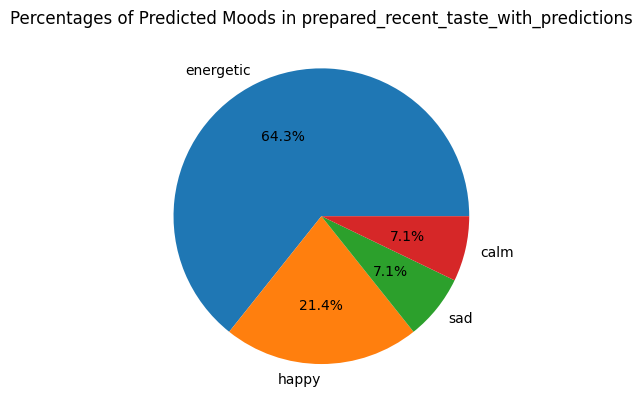

------------------------------------------------------------------------


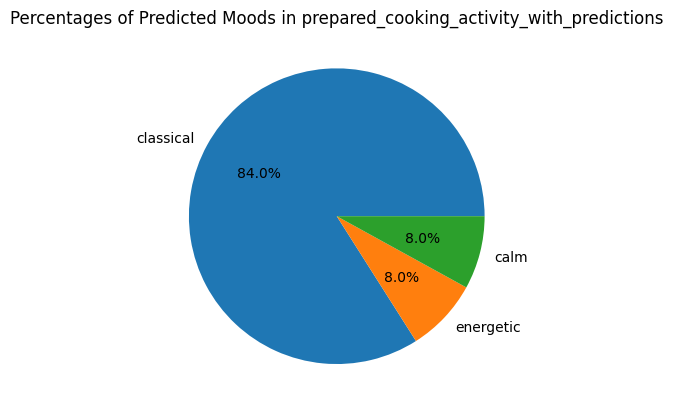

------------------------------------------------------------------------


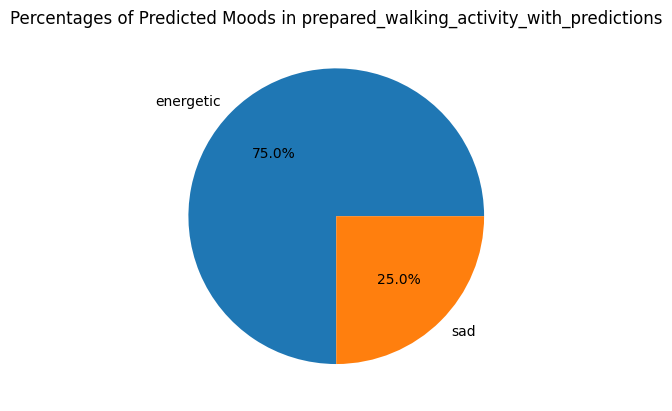

------------------------------------------------------------------------
------------------------------------------------------------------------


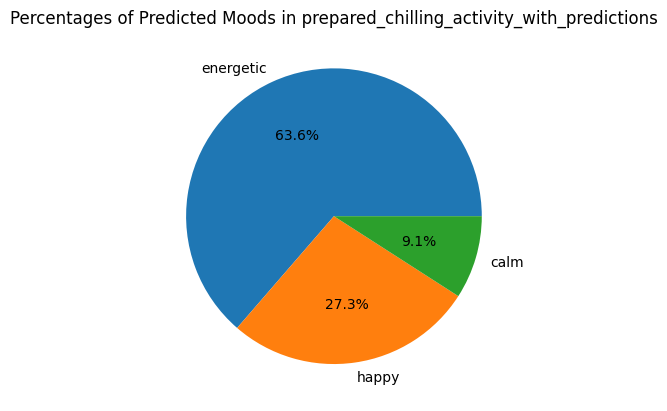

------------------------------------------------------------------------
------------------------------------------------------------------------


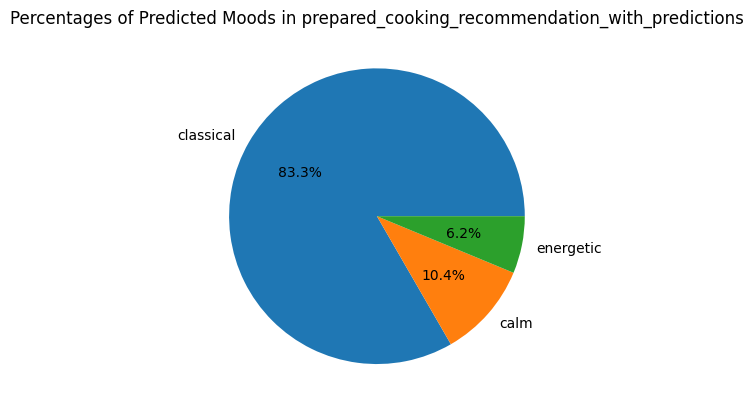

------------------------------------------------------------------------
------------------------------------------------------------------------


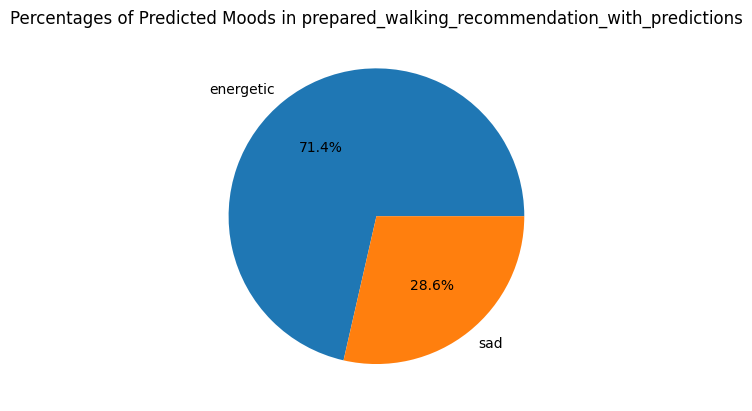

------------------------------------------------------------------------
------------------------------------------------------------------------


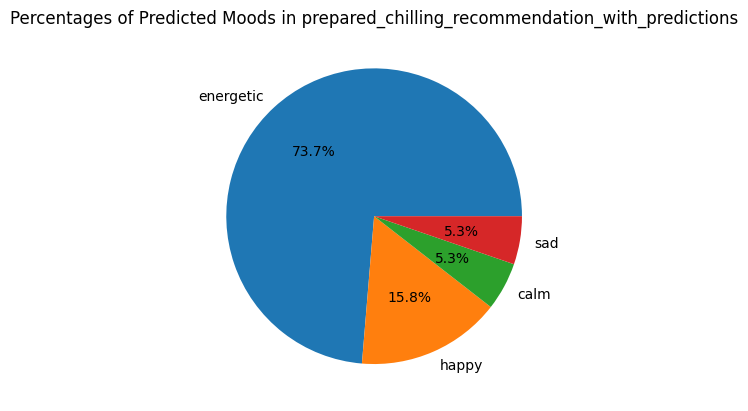

------------------------------------------------------------------------
------------------------------------------------------------------------


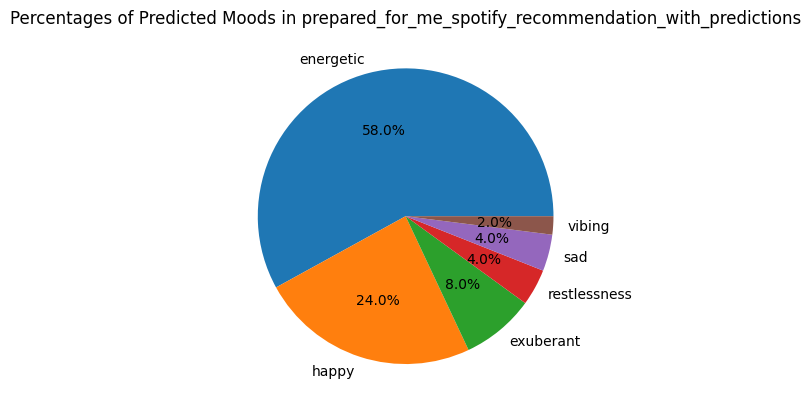

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def create_mood_pie_chart(csv_path):
    """
    Creates a pie chart of the percentages of each mood in a CSV file's "Predicted Mood" column.

    Args:
        csv_path (str): The path to the CSV file.
    """
    df = pd.read_csv(csv_path)

    # Get mood counts and calculate percentages
    mood_counts = df['Predicted Mood'].value_counts()
    total_count = len(df['Predicted Mood'])
    mood_percentages = mood_counts / total_count * 100

    # Get CSV filename without extension
    filename = os.path.splitext(os.path.basename(csv_path))[0]

    # Create pie chart
    plt.pie(mood_percentages, labels=mood_percentages.index, autopct='%1.1f%%')
    plt.title(f"Percentages of Predicted Moods in {filename}")  # Use filename in title
    plt.show()

# Example usage:
csv_path = 'prepared_cooking_recommendation_with_predictions.csv'  # Replace with your CSV file path
csv_path1 = 'prepared_chilling_recommendation_with_predictions.csv'
csv_path2 = 'prepared_walking_recommendation_with_predictions.csv'
csv_path3 = 'prepared_for_me_spotify_recommendation_with_predictions.csv'
csv_path4 = 'prepared_cooking_activity_with_predictions.csv'
csv_path5 = 'prepared_walking_activity_with_predictions.csv'
csv_path6 = 'prepared_chilling_activity_with_predictions.csv'
csv_path7 = 'prepared_recent_taste_with_predictions.csv'

print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
create_mood_pie_chart(csv_path7)
print('------------------------------------------------------------------------')
create_mood_pie_chart(csv_path4)

print('------------------------------------------------------------------------')
create_mood_pie_chart(csv_path5)
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
create_mood_pie_chart(csv_path6)
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
create_mood_pie_chart(csv_path)
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
create_mood_pie_chart(csv_path2)
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
create_mood_pie_chart(csv_path1)
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
create_mood_pie_chart(csv_path3)